[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gomar0801/BachGen/blob/main/notebooks/Pipeline.ipynb)

In [1]:
%%capture
# Clone the BachGen repository
!rm -rf BachGen && git clone https://github.com/gomar0801/BachGen.git
!chmod +x ./BachGen/scripts/setup.sh
!./BachGen/scripts/setup.sh

In [2]:
from bachgen.download_data import download_all
from bachgen.extract import extract_archive
from bachgen.data_filter import load_and_filter_piano_classical
from bachgen.mxl_to_musicxml import convert_mxl_to_musicxml
from bachgen.batch_convert_mxl_to_musicxml import convert_many_mxl_to_musicxml
from bachgen.display_and_play_partition import display_and_play
from bachgen.score_to_tokens_simplify import MusicXML_to_tokens
from bachgen.batch_tokenize_with_stats import tokenize_folder_with_stats
from bachgen.tokens_to_musicxml import convert_tokens_to_musicxml
from bachgen.vocab_utils import load_vocab, decode_ids_file
from bachgen.vocab_pipeline import build_and_encode

/usr/local/lib/python3.12/dist-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Telechargement des données

In [6]:
download_all()

⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/mxl.tar.gz?download=1 ...
✅ Fichier téléchargé : data/mxl.tar.gz
⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/PDMX.csv?download=1 ...
✅ Fichier téléchargé : data/PDMX.csv


In [7]:
extract_folder=extract_archive("/content/data/mxl.tar.gz")

📦 Extraction de /content/data/mxl.tar.gz vers data/mxl ...
✅ Extraction terminée dans : data/mxl


# Filtrage

In [8]:
df_piano_classical = load_and_filter_piano_classical()

🎹 24008 partitions de piano (genre classique) trouvées.


# MXL to MusicXML

In [9]:
MXL_ROOT = "data/mxl"
OUT_DIR  = "data/musicxml_classical_piano_convert"

done, errors = convert_many_mxl_to_musicxml(
    items=df_piano_classical,           # DataFrame filtré : df_piano_classical
    mxl_root=MXL_ROOT,
    out_dir=OUT_DIR,
    path_col="mxl",                     # adapte si ta colonne s'appelle autrement
    timeout=10,
    max_workers=1,                      # music21 est peu thread-safe → rester bas
    resume=True,
    error_log_csv="data/convert_errors.csv",
)

Converting: 100%|██████████| 24004/24004 [4:29:00<00:00,  1.49it/s]

✅ Conversion terminée: 23806 fichiers créés dans data/musicxml_classical_piano_convert
⚠️ 198 problème(s). Exemples:
  - ('data/mxl/mxl/1/40/QmbrSSE9PT79WZvdB4yQv5149fTcs3yuzSeRVm3yYmy1Wh.mxl', 'the object (<music21.stream.Measure 17 offset=48.0>, id()=136355895096240 is already found in this Stream (<music21.stream.Part Soprano Alto>, id()=136355714980016)')
  - ('data/mxl/mxl/1/51/QmbWzooTBsuRDYQMQ4VAiaC9NyazN4sM6i4YBq3a8Gb83s.mxl', 'the object (<music21.stream.Measure 34 offset=64.5>, id()=136355646625632 is already found in this Stream (<music21.stream.Part Piano>, id()=136355916216032)')
  - ('data/mxl/mxl/1/23/QmbhFfCTvxiJi6TgGaY5MpFTnd1hD9fhFxAzP8Gtfe1jym.mxl', 'the object (<music21.stream.Measure 19 offset=54.0>, id()=136355912896720 is already found in this Stream (<music21.stream.Part Staff>, id()=136355623615952)')
  - ('data/mxl/mxl/1/8/Qmb99NMtky28eyP1NpRQwS5dhHFM2VrhZNA8JBgWhdLP76.mxl', 'the object (<music21.stream.Measure 12 offset=42.0>, id()=136355916212528 is already 

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Pensez à sauvegarder pour ne pas tout relancer à chaque fois
!cp -r /content/data/musicxml_classical_piano_convert /content/drive/MyDrive/Stage\ MusicXML/musicxml_classical_piano_convert_100%     #à adapter

# MusicXML to Tokens (+statistics)

## Sans statistique

In [ ]:
from pathlib import Path

SRC_DIR = Path("data/musicxml_classical_piano")  # dossier avec les .musicxml
OUT_DIR = Path("data/tokens_classical_piano")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for xml_file in SRC_DIR.glob("*.musicxml"):
    try:
        tokens = MusicXML_to_tokens(str(xml_file))
        out_file = OUT_DIR / (xml_file.stem + ".txt")
        with open(out_file, "w", encoding="utf-8") as f:
            f.write(" ".join(tokens))
        print(f"✅ {xml_file.name} → {out_file.name}")
    except Exception as e:
        print(f"❌ {xml_file.name} -> {e}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  → Backup : -40320
    • Note: Rest, Voice: 2, Start: 0, Duration: 30240, Chord: False
    • Note: G4, Voice: 2, Start: 30240, Duration: 10080, Chord: False
[Résultat] 10 notes extraites avec positions.


  → 10 notes extraites avec positions
  → Notes triées par position :
    • Pos     0, Voice 1, Note: G4
    • Pos     0, Voice 1, Note: D5
    • Pos     0, Voice 2, Note: Rest
    • Pos 10080, Voice 1, Note: A4
    • Pos 10080, Voice 1, Note: D5
    • Pos 20160, Voice 1, Note: G4
    • Pos 20160, Voice 1, Note: D5
    • Pos 30240, Voice 1, Note: C5
    • Pos 30240, Voice 2, Note: G4
    • Pos 35280, Voice 1, Note: D5

  → Position 0 : 3 élément(s)
    ⚠ Silences superposés détectés, ils sont ignorés.
    ↳ Durée harmonisée de l'accord : 10080

  → Position 10080 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Position 20160 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Posit

KeyboardInterrupt: 

## Avec Statistiques

In [ ]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/musicxml_classical_piano_convert  /content/data

In [17]:
from pathlib import Path

SRC_DIR = Path("/content/data/musicxml_classical_piano_convert")
TOK_DIR = Path("data/tokens_classical_piano_simplify")
STATS_CSV = Path("data/tokenization_stats_V2.csv")

_ = tokenize_folder_with_stats(
    src_dir=SRC_DIR,
    out_tok_dir=TOK_DIR,
    stats_csv=STATS_CSV,
    note_name=True,
    pattern="*.musicxml",
    resume=True,
    verbose=True,
)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
✅ Qmc1EfZpt1yffGHqEgjZyPg4EgvTZHpjBdVpTLxA8s7mrR.musicxml  [transp 0.526% | overl.rest 1.316% | harmo 4.211% (count=16)]
✅ Qmc1Es8xdB69pWzmedE2Gmb5eUvZ2e59cyV2boPRRTZVta.musicxml  [transp 0.0% | overl.rest 0.503% | harmo 1.508% (count=6)]
✅ Qmc1FV8qWr7u6hLGVeogtNHtvcjVoVtjZRea4umPYu9dEv.musicxml  [transp 0.0% | overl.rest 2.344% | harmo 15.625% (count=20)]
✅ Qmc1HM8Wn94b2BBEU5b3qw11KZ8G5FZ6aEKrhmMhWCuofS.musicxml  [transp 1.325% | overl.rest 8.609% | harmo 20.53% (count=31)]
✅ Qmc1Hx8pXg81uADsxMSnBB4CPN37TBy3P2JiRDMT7Dxpvy.musicxml  [transp 2.575% | overl.rest 7.725% | harmo 31.33% (count=73)]
✅ Qmc1LppixQyuSDLo5s4eW3ot8SCxbpLsSxY1MJHvdvhRsS.musicxml  [transp 1.55% | overl.rest 6.977% | harmo 24.031% (count=31)]
✅ Qmc1MFuKa9coeWwvwA72zyvqPYzRbUWNQih8eCXQmYpAbT.musicxml  [transp 0.0% | overl.rest 10.0% | harmo 40.0% (count=52)]
✅ Qmc1Npaj2BhHu2cWj7psNTFhQw1t4E1J8AX9Erp3dWzHGi.musicxml  [transp 3.472% | overl.r

In [18]:
!cp -r /content/data/tokens_classical_piano_simplify /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_simplify_100%

In [20]:
!cp -r /content/data/tokenization_stats_V2.csv /content/drive/MyDrive/Stage\ MusicXML/tokenization_stats_V2.csv

Resumé du tableau de statistique :    
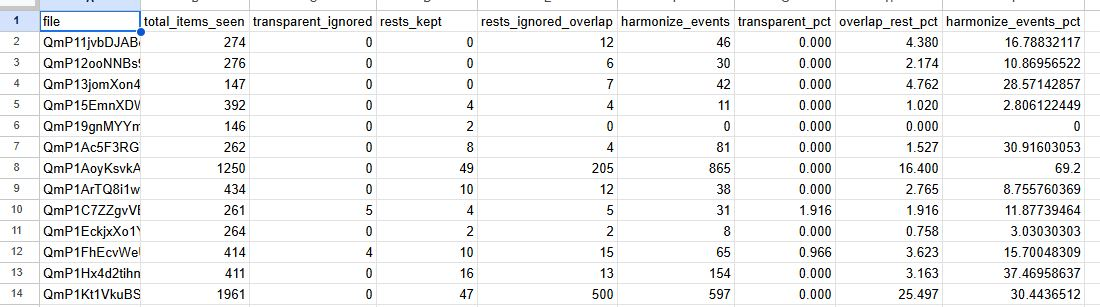
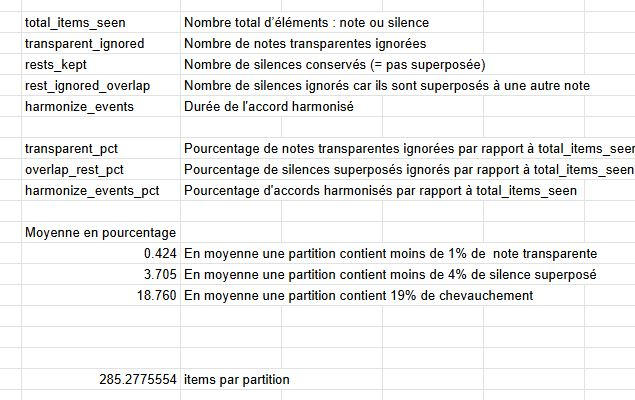

# Construction dictionaire tokens<->id

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_simplify_100%/. /content/data/tokens_classical_piano_simplify_100%/

In [15]:
from pathlib import Path

TOK_DIR   = Path("/content/data/tokens_classical_piano_simplify_100%")
IDS_DIR   = Path("data/token_ids_simplify_100%")
VOCAB_OUT = Path("data/vocab/token2id.json")

# 1) Construire vocab + encoder tous les tokens -> ids
token2id, vocab_size = build_and_encode(
    token_dir=TOK_DIR,
    vocab_out=VOCAB_OUT,
    ids_out_dir=IDS_DIR,
    specials=("[PAD]", "[UNK]", "<BOS>", "<EOS>"),
    min_freq=1,
    pattern="*.txt",
    add_bos=True,
    add_eos=True,
)
print("Vocab size:", vocab_size)

# 2) Recharger plus tard le vocab (si nécessaire)
token2id, id2token = load_vocab(VOCAB_OUT)

Vocab size: 364


'\n# 3) Décoder un fichier d\'IDs pour contrôle rapide\nsome_ids = next(IDS_DIR.glob("*.ids.txt"))\ndecoded = decode_ids_file(some_ids, VOCAB_OUT, join_tokens=True)\nprint(decoded[:200], "...")\n'

In [17]:
print(token2id)

{'[PAD]': 0, '[UNK]': 1, '<BOS>': 2, '<EOS>': 3, 'len_1': 4, 'len_1/2': 5, 'bar': 6, 'note_D4': 7, 'len_1/4': 8, 'note_G4': 9, 'note_C4': 10, 'note_F4': 11, 'note_G3': 12, 'len_2': 13, 'note_A4': 14, 'note_E4': 15, 'note_A3': 16, 'note_Eb4': 17, 'note_Bb3': 18, 'note_C5': 19, 'note_F3': 20, 'rest': 21, 'note_D3': 22, 'note_Bb4': 23, 'note_D5': 24, 'note_C3': 25, 'len_3/2': 26, 'note_B3': 27, 'note_B4': 28, 'note_Eb3': 29, 'note_Ab3': 30, 'note_F#4': 31, 'len_3/4': 32, 'note_Bb2': 33, 'note_E3': 34, 'note_Ab4': 35, 'len_3': 36, 'note_A2': 37, 'note_E5': 38, 'note_C#4': 39, 'note_F#3': 40, 'note_G2': 41, 'note_Db4': 42, 'len_1/3': 43, 'note_Ab2': 44, 'len_4': 45, 'note_C#5': 46, 'note_B2': 47, 'note_Eb5': 48, 'note_F5': 49, 'note_G#4': 50, 'note_Db3': 51, 'note_G5': 52, 'clef_treble': 53, 'note_G#3': 54, 'clef_bass': 55, 'time_4/4': 56, 'note_A5': 57, 'note_Db5': 58, 'L': 59, 'R': 60, 'note_F#5': 61, 'note_F2': 62, 'note_D#4': 63, 'note_C#3': 64, 'note_Gb4': 65, 'len_1/8': 66, 'len_1/6':

In [16]:

# 3) Décoder un fichier d'IDs pour contrôle rapide
some_ids = next(IDS_DIR.glob("*.ids.txt"))
decoded = decode_ids_file(some_ids, VOCAB_OUT, join_tokens=True)
print(decoded[:200], "...")


<BOS> R bar key_natural_0 time_4/4 clef_treble note_C4 note_G4 len_2 note_C4 note_E4 len_1 note_C4 note_C4 len_1 bar note_C4 note_A4 len_3/2 note_C4 note_G4 len_1/2 note_C4 note_G4 len_2 bar note_C4 n ...


In [18]:
!cp -r /content/data/token_ids_simplify_100% /content/drive/MyDrive/Stage\ MusicXML/

In [28]:
!cp -r /content/data/vocab_100% /content/drive/MyDrive/Stage\ MusicXML/

# Training (Model GPT2 from scratch)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/token_ids_simplify_100% /content/data/token_ids_simplify/

In [12]:
print(len(list(Path("/content/data/token_ids_simplify/token_ids_simplify_100%").glob("*.ids.txt"))))

7220


In [9]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/vocab_100%/. /content/data/vocab/

In [7]:
from transformers import GPT2Config, GPT2LMHeadModel, TrainingArguments, Trainer

In [ ]:
from pathlib import Path
from bachgen.training.splits import (
    load_vocab_ids, load_all_ids, split_sequences, save_split, load_split
)
from bachgen.training.train_gpt2 import (
    build_gpt2_config, make_datasets, default_training_args,
    train_gpt2, evaluate, save_model
)

# Paths
VOCAB_PATH  = Path("/content/data/vocab/token2id.json")
IDS_DIR     = Path("/content/data/token_ids_simplify/token_ids_simplify_100%")       # tes .ids.txt
SPLIT_DIR   = Path("data/pretokenized_splits")
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Vocab & specials
VOCAB_SIZE, PAD_ID, BOS_ID, EOS_ID = load_vocab_ids(VOCAB_PATH)
print("VOCAB:", VOCAB_SIZE, "PAD/BOS/EOS:", PAD_ID, BOS_ID, EOS_ID)

# 2) Charger toutes les séquences d’IDs & faire les splits
all_sequences = load_all_ids(IDS_DIR, suffix=".txt")   # si tes fichiers finissent par .ids.txt, mets suffix=".ids.txt"
train_seqs, valid_seqs, test_seqs = split_sequences(all_sequences, train_ratio=0.90, valid_ratio=0.05, seed=42)

# (optionnel) Sauvegarder les splits
save_split(train_seqs, SPLIT_DIR / "train_ids.txt")
save_split(valid_seqs, SPLIT_DIR / "valid_ids.txt")
save_split(test_seqs,  SPLIT_DIR / "test_ids.txt")

# 3) Datasets
BLOCK = 1024
train_ds, valid_ds, test_ds = make_datasets(train_seqs, valid_seqs, test_seqs, block_size=BLOCK)

# 4) Config + TrainingArguments + entraînement
config = build_gpt2_config(
    vocab_size=VOCAB_SIZE, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID,
    n_positions=BLOCK, n_embd=1024, n_layer=4, n_head=4
)

targs = default_training_args(out_dir=Path("./gpt2-musicxml-ids"),
                              num_epochs=8, per_device_bs=2, grad_accum=4)

trainer, model = train_gpt2(train_ds, valid_ds, config, targs)

# 5) Évaluations
val_loss, val_ppl = evaluate(trainer, valid_ds)
print("Validation:", val_loss, val_ppl)
test_loss, test_ppl = evaluate(trainer, test_ds)
print("Test:", test_loss, test_ppl)

# 6) Sauvegarde
save_model(trainer, Path("./final_model_gpt2_ids"))

VOCAB: 364 PAD/BOS/EOS: 0 2 3
  -> 10259 chunks de taille 1024 (à partir de 20766 morceaux)
  -> 578 chunks de taille 1024 (à partir de 1153 morceaux)
  -> 547 chunks de taille 1024 (à partir de 1155 morceaux)


Epoch,Training Loss,Validation Loss


In [ ]:
save_model(trainer, Path("/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"))

## Model gpt2 V1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json, torch
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Config

In [ ]:
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab/token2id.json"
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    tok2id = json.load(f)

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V1"
model  = GPT2LMHeadModel.from_pretrained(str(MODEL_DIR))

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)


Generated ids: [2, 2, 60, 6, 87, 56, 53, 19, 35, 4, 23, 9, 5, 35, 35, 5, 6, 35, 11, 13, 35, 11, 4, 6, 19, 17, 5, 23, 9, 4, 35, 11, 5, 23, 9, 5, 35, 11, 5, 23, 11, 5, 19, 35, 5, 6, 19, 35, 4, 23, 9, 4, 35, 11, 4, 17, 17, 5, 17, 35, 5, 6, 19, 35, 4, 19, 35, 4, 35, 4, 35, 11, 4, 6, 17, 9, 13, 35, 11, 4, 35, 17, 4, 6, 23, 17, 4, 19, 17, 4, 48, 35, 4, 23, 17, 4, 6, 23, 9, 4, 35, 11, 4, 9, 17, 4, 35, 11, 4, 6, 9, 17, 36, 23, 17, 4, 6, 19, 17, 4, 19, 17, 4, 48, 35, 4, 19, 35, 4, 6, 23, 9, 4, 23, 9, 4, 35, 11, 4, 9, 17, 4, 6, 35, 17, 36, 17, 17, 4, 6, 19, 17, 4, 19, 66, 4, 19, 17, 4, 19, 17, 4, 35, 17, 4, 6, 23, 7, 36, 17, 10, 4, 6, 11, 10, 36, 17, 10, 4, 6, 19, 17, 4, 6, 23, 17, 36, 23, 11, 4, 6, 61, 11, 36, 48, 17, 4, 6, 61, 17, 4, 19, 17, 4, 19, 17, 4, 23, 17, 4, 6, 35, 17, 13, 23, 11, 4, 6, 35, 17, 36, 21, 4, 59, 6, 87, 56, 55, 29, 29, 4, 30, 29, 4, 30, 43, 4, 29, 29, 4, 6, 30, 43, 36, 30, 43, 4, 6, 30, 43, 4, 30, 43, 4, 30, 43, 4, 30, 38, 4, 6, 20, 51, 36, 18, 51, 4, 6, 10, 29, 4, 10, 25,

In [ ]:
import json
from pathlib import Path

# chemins
VOCAB_PATH = Path("/content/data/vocab/token2id.json")  # adapte si besoin

# charge le vocab (token -> id), puis inverse (id -> token)
with VOCAB_PATH.open("r", encoding="utf-8") as f:
    tok2id = json.load(f)
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 1))           ####pb ici car bos= 2 et eos = 3, car unk=1
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 2))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)


Exemple tokens: ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4

In [ ]:
# mauvais token: ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'note_Eb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Gb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_D4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_C4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Db5', 'note_F4', 'len_3', 'note_Eb5', 'note_Eb4', 'len_1', 'bar', 'note_Db5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_2', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'rest', 'len_1', 'L', 'bar', 'key_flat_4', 'time_4/4', 'clef_bass', 'note_Eb3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Eb3', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_A2', 'len_1', 'bar', 'note_F3', 'note_Db3', 'len_3', 'note_Bb3', 'note_Db3', 'len_1', 'bar', 'note_C4', 'note_Eb3', 'len_1', 'note_C4', 'note_C3', 'len_1', 'note_C4', 'note_Eb3', 'len_1', 'note_Db4', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_C3', 'len_1', 'note_Db4', 'note_Bb2', 'len_1', 'note_Db4']

#je corrige en enlevant la denrniere note pour finir par un token len_
token1= ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_Ab4', 'len_1/2', 'bar', 'note_Ab4', 'note_F4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Bb4', 'note_F4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Ab4', 'len_1/2', 'bar', 'note_C5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'note_Ab4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_Eb4', 'note_G4', 'len_2', 'note_Ab4', 'note_F4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Ab4', 'len_1', 'note_C5', 'note_Ab4', 'len_1', 'bar', 'note_Bb4', 'note_G4', 'len_1', 'note_Bb4', 'note_G4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'note_Eb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Gb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_D4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_C4', 'len_3', 'note_Eb4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_3', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Db5', 'note_F4', 'len_3', 'note_Eb5', 'note_Eb4', 'len_1', 'bar', 'note_Db5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_C5', 'note_Eb4', 'len_1', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_2', 'note_Bb4', 'note_F4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_3', 'rest', 'len_1', 'L', 'bar', 'key_flat_4', 'time_4/4', 'clef_bass', 'note_Eb3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Eb3', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Eb3', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_A2', 'len_1', 'bar', 'note_F3', 'note_Db3', 'len_3', 'note_Bb3', 'note_Db3', 'len_1', 'bar', 'note_C4', 'note_Eb3', 'len_1', 'note_C4', 'note_C3', 'len_1', 'note_C4', 'note_Eb3', 'len_1', 'note_Db4', 'note_Eb3', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_3', 'note_Ab3', 'note_Ab2', 'len_1', 'bar', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_Ab2', 'len_1', 'note_Ab3', 'note_C3', 'len_1', 'note_Db4', 'note_Bb2', 'len_1']

In [ ]:
score = convert_tokens_to_musicxml(token1,"output.musicxml")

On obtient une partition correcte

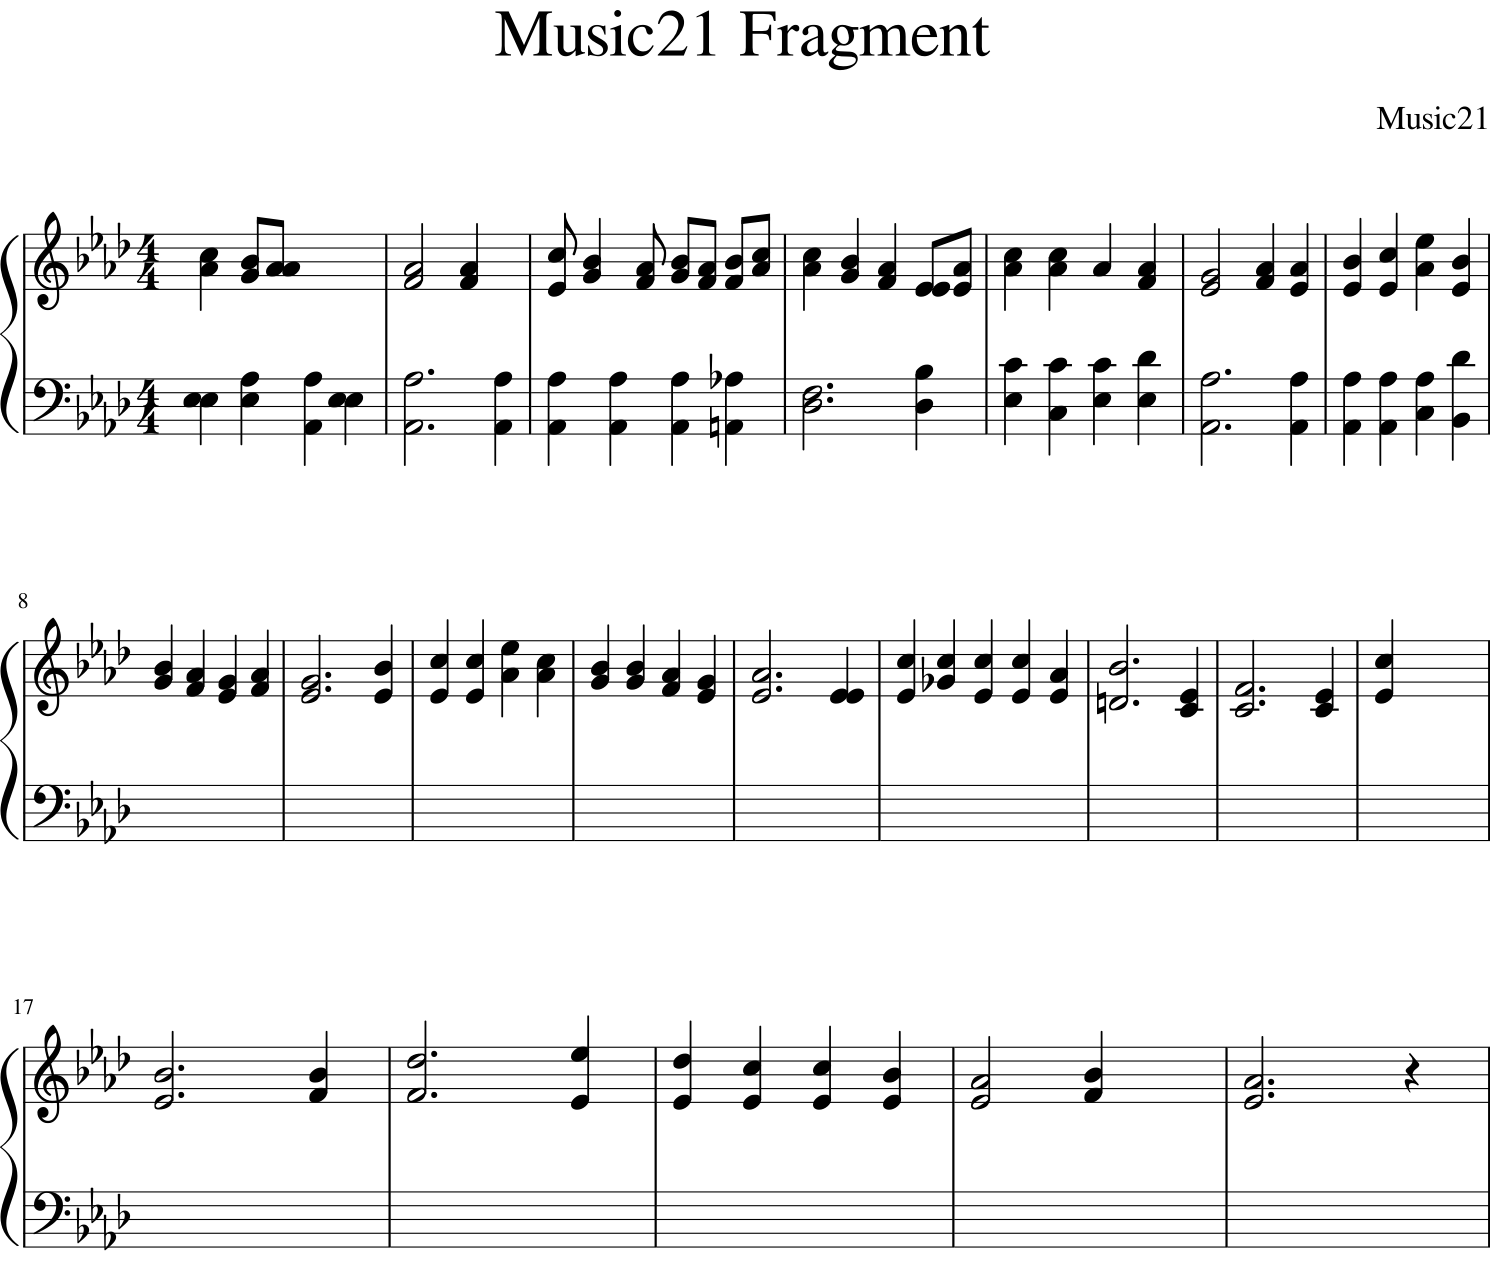

In [ ]:
display_and_play("/content/output.musicxml")

## Model gpt2 V2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json, torch
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Config

In [ ]:
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab/token2id.json"
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    tok2id = json.load(f)

In [ ]:
print(tok2id)

{'[PAD]': 0, '[UNK]': 1, '<BOS>': 2, '<EOS>': 3, 'len_1': 4, 'len_1/2': 5, 'bar': 6, 'note_D4': 7, 'len_1/4': 8, 'note_G4': 9, 'note_C4': 10, 'note_F4': 11, 'note_G3': 12, 'len_2': 13, 'note_A4': 14, 'note_E4': 15, 'note_A3': 16, 'note_Eb4': 17, 'note_Bb3': 18, 'note_C5': 19, 'note_F3': 20, 'rest': 21, 'note_D3': 22, 'note_Bb4': 23, 'note_D5': 24, 'note_C3': 25, 'len_3/2': 26, 'note_B3': 27, 'note_B4': 28, 'note_Eb3': 29, 'note_Ab3': 30, 'note_F#4': 31, 'len_3/4': 32, 'note_Bb2': 33, 'note_E3': 34, 'note_Ab4': 35, 'len_3': 36, 'note_E5': 37, 'note_A2': 38, 'note_C#4': 39, 'note_F#3': 40, 'note_Db4': 41, 'note_G2': 42, 'note_Ab2': 43, 'len_4': 44, 'len_1/3': 45, 'note_C#5': 46, 'note_B2': 47, 'note_Eb5': 48, 'note_F5': 49, 'note_G#4': 50, 'note_Db3': 51, 'note_G5': 52, 'clef_treble': 53, 'note_G#3': 54, 'clef_bass': 55, 'time_4/4': 56, 'note_A5': 57, 'note_F#5': 58, 'L': 59, 'R': 60, 'note_Db5': 61, 'note_D#4': 62, 'note_F2': 63, 'len_1/6': 64, 'note_C#3': 65, 'note_Gb4': 66, 'len_1/8':

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"
model  = GPT2LMHeadModel.from_pretrained(str(MODEL_DIR))

In [ ]:
BOS_TOKEN_ID = tok2id.get("<BOS>", tok2id.get("<bos>",2 ))
EOS_TOKEN_ID = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

### Tentative 1

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

Generated ids: [2, 2, 60, 6, 90, 119, 53, 7, 7, 13, 17, 17, 4, 11, 7, 4, 9, 17, 4, 6, 9, 17, 13, 11, 7, 13, 17, 17, 13, 6, 11, 7, 36, 23, 7, 13, 23, 17, 4, 6, 19, 17, 4, 9, 17, 4, 9, 17, 4, 11, 7, 13, 11, 7, 13, 6, 23, 7, 44, 23, 7, 13, 6, 11, 7, 36, 11, 7, 13, 23, 7, 4, 6, 19, 17, 4, 23, 7, 4, 23, 7, 4, 23, 7, 13, 14, 10, 13, 6, 23, 7, 44, 23, 7, 4, 19, 17, 4, 6, 24, 11, 13, 24, 11, 4, 24, 9, 4, 6, 24, 11, 13, 19, 7, 13, 23, 7, 4, 6, 19, 17, 4, 9, 17, 4, 23, 17, 4, 23, 17, 4, 19, 17, 13, 6, 19, 17, 4, 23, 7, 4, 14, 10, 4, 23, 7, 13, 6, 23, 7, 36, 24, 7, 13, 59, 6, 90, 111, 55, 20, 33, 13, 20, 33, 4, 20, 33, 4, 6, 12, 29, 13, 18, 29, 4, 18, 29, 4, 18, 29, 4, 6, 18, 33, 13, 18, 33, 13, 20, 33, 4, 20, 33, 4, 6, 16, 20, 4, 20, 20, 4, 20, 33, 13, 20, 33, 13, 6, 20, 33, 44, 18, 33, 4, 18, 33, 4, 6, 18, 29, 13, 18, 29, 4, 18, 29, 4, 18, 29, 4, 18, 29, 13, 6, 18, 20, 33, 44, 20, 33, 4, 6, 20, 33, 13, 20, 33, 4, 20, 33, 4, 12, 33, 13, 6, 20, 33, 92, 6, 20, 33, 44, 20, 33, 4, 20, 33, 4, 20, 33,

In [ ]:
import json
from pathlib import Path

id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_flat_2', 'time_3/2', 'clef_treble', 'note_D4', 'note_D4', 'len_2', 'note_Eb4', 'note_Eb4', 'len_1', 'note_F4', 'note_D4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_2', 'note_F4', 'note_D4', 'len_2', 'note_Eb4', 'note_Eb4', 'len_2', 'bar', 'note_F4', 'note_D4', 'len_3', 'note_Bb4', 'note_D4', 'len_2', 'note_Bb4', 'note_Eb4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_F4', 'note_D4', 'len_2', 'note_F4', 'note_D4', 'len_2', 'bar', 'note_Bb4', 'note_D4', 'len_4', 'note_Bb4', 'note_D4', 'len_2', 'bar', 'note_F4', 'note_D4', 'len_3', 'note_F4', 'note_D4', 'len_2', 'note_Bb4', 'note_D4', 'len_1', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_Bb4', 'note_D4', 'len_1', 'note_Bb4', 'note_D4', 'len_1', 'note_Bb4', 'note_D4', 'len_2', 'note_A4', 'note_C4', 'len_2', 'bar', 'note_Bb4', 'note_D4', 'len_4', 'note_Bb4', 'note_D4', 'len_1', 'note_C5', 'note_Eb4', 'len_1',

In [ ]:
score = convert_tokens_to_musicxml(tokens,"output.musicxml")

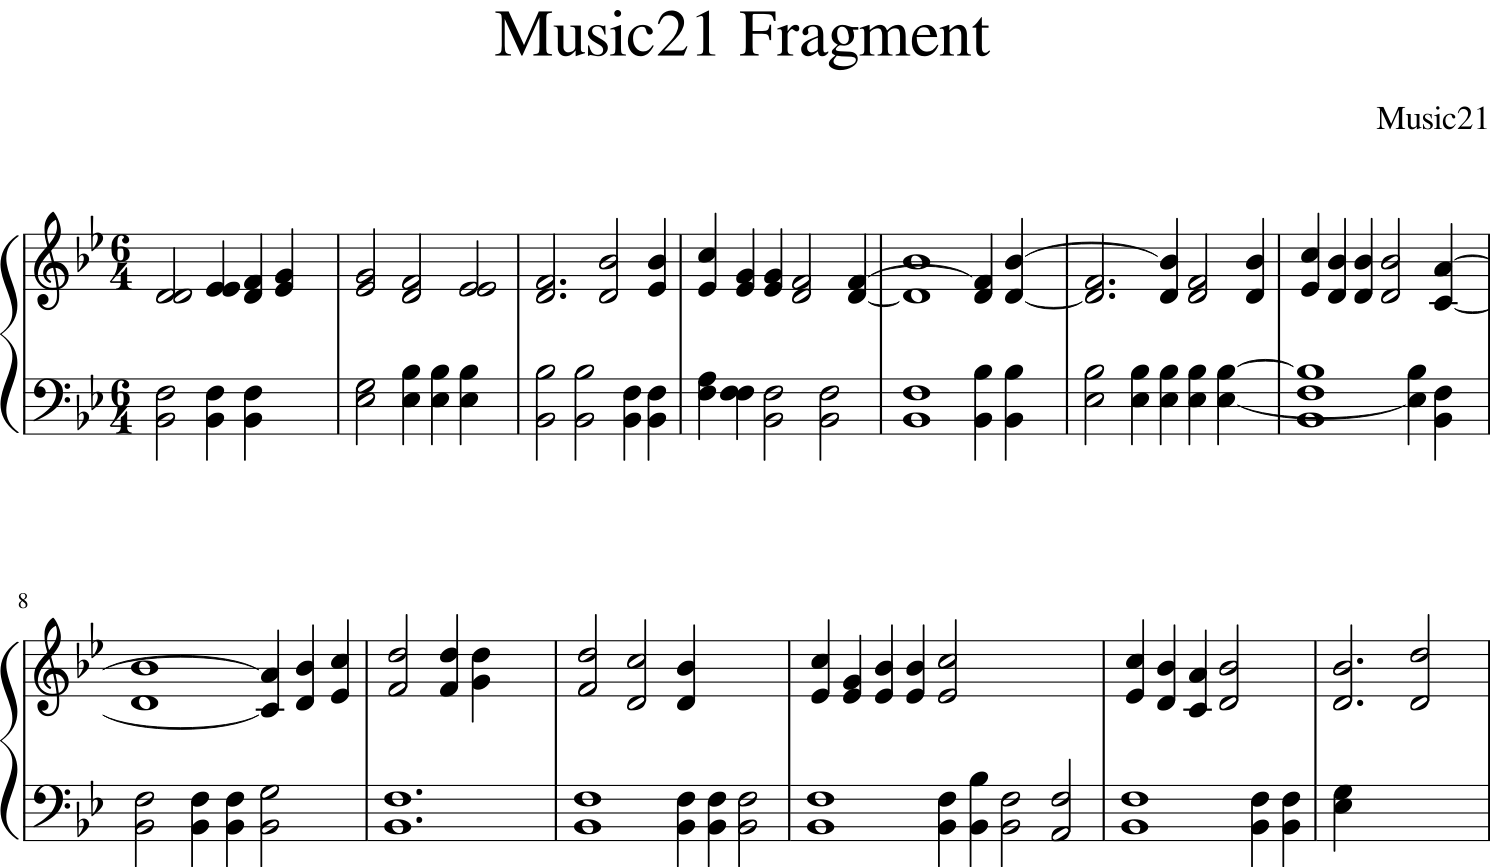

In [ ]:
display_and_play("/content/output.musicxml")

### Tentative 2

In [ ]:
def tok(prompt):
    return tok2id[prompt]

In [ ]:
primer_tokens = ["R", "bar", "key_flat_3", "time_4/4", "clef_treble"]
primer_ids = [tok(t) for t in primer_tokens if t in tok2id]
primer_ids = [BOS_TOKEN_ID] + primer_ids

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([primer_ids], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

Generated ids: [2, 60, 6, 85, 56, 53, 23, 9, 13, 19, 9, 5, 23, 9, 5, 23, 9, 4, 9, 17, 4, 6, 35, 17, 4, 9, 17, 4, 11, 7, 13, 6, 17, 17, 44, 6, 19, 17, 4, 48, 17, 5, 23, 17, 5, 19, 17, 4, 35, 17, 4, 6, 23, 17, 4, 9, 17, 4, 9, 17, 13, 6, 11, 7, 5, 9, 17, 5, 35, 17, 5, 23, 17, 5, 19, 17, 5, 23, 17, 4, 35, 17, 4, 6, 9, 17, 44, 6, 23, 9, 13, 19, 35, 5, 23, 9, 5, 19, 35, 5, 6, 23, 9, 44, 6, 23, 9, 13, 23, 9, 5, 23, 9, 5, 23, 9, 5, 48, 9, 4, 9, 17, 4, 6, 35, 17, 4, 9, 17, 4, 11, 7, 13, 6, 17, 5, 17, 17, 5, 9, 17, 5, 9, 17, 5, 35, 11, 5, 9, 17, 5, 35, 11, 5, 35, 11, 4, 6, 11, 7, 26, 17, 5, 17, 4, 59, 6, 85, 56, 55, 12, 29, 13, 12, 29, 5, 18, 29, 5, 18, 29, 5, 18, 29, 4, 6, 10, 43, 4, 18, 33, 4, 18, 33, 13, 6, 12, 29, 44, 6, 12, 29, 4, 12, 29, 5, 12, 29, 5, 30, 29, 4, 10, 29, 4, 6, 18, 29, 4, 18, 12, 4, 18, 18, 13, 6, 18, 29, 13, 18, 29, 4, 18, 29, 4, 6, 10, 43, 4, 33, 18, 5, 16, 5, 12, 25, 4, 10, 25, 4, 6, 10, 63, 4, 33, 18, 5, 30, 5, 18, 12, 29, 4, 17, 12, 4, 6, 17, 30, 4, 18, 30, 4, 18, 12, 1

In [ ]:
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_flat_3', 'time_4/4', 'clef_treble', 'note_Bb4', 'note_G4', 'len_2', 'note_C5', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_F4', 'note_D4', 'len_2', 'bar', 'note_Eb4', 'note_Eb4', 'len_4', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1/2', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_2', 'bar', 'note_F4', 'note_D4', 'len_1/2', 'note_G4', 'note_Eb4', 'len_1/2', 'note_Ab4', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1/2', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_4', 'bar', 'note_Bb4', 'note_G4', 'len_2', 'note_C5', 'note_Ab4', 'len_1/2'

In [ ]:
tokens1= ['R', 'bar', 'key_flat_3', 'time_4/4', 'clef_treble', 'note_Bb4', 'note_G4', 'len_2', 'note_C5', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_F4', 'note_D4', 'len_2', 'bar', 'note_Eb4', 'note_Eb4', 'len_4', 'bar', 'note_C5', 'note_Eb4', 'len_1', 'note_Eb5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1/2', 'note_C5', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_Bb4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_2', 'bar', 'note_F4', 'note_D4', 'len_1/2', 'note_G4', 'note_Eb4', 'len_1/2', 'note_Ab4', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1/2', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Bb4', 'note_Eb4', 'len_1', 'note_Ab4', 'note_Eb4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_4', 'bar', 'note_Bb4', 'note_G4', 'len_2', 'note_C5', 'note_Ab4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_C5', 'note_Ab4', 'len_1/2', 'bar', 'note_Bb4', 'note_G4', 'len_4', 'bar', 'note_Bb4', 'note_G4', 'len_2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Bb4', 'note_G4', 'len_1/2', 'note_Eb5', 'note_G4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'bar', 'note_Ab4', 'note_Eb4', 'len_1', 'note_G4', 'note_Eb4', 'len_1', 'note_F4', 'note_D4', 'len_2', 'bar', 'note_Eb4', 'len_1/2', 'note_Eb4', 'note_Eb4', 'len_1/2', 'note_G4', 'note_Eb4', 'len_1/2', 'note_G4', 'note_Eb4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_G4', 'note_Eb4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1/2', 'note_Ab4', 'note_F4', 'len_1', 'bar', 'note_F4', 'note_D4', 'len_3/2', 'note_Eb4', 'len_1/2', 'note_Eb4', 'len_1', 'L', 'bar', 'key_flat_3', 'time_4/4', 'clef_bass', 'note_G3', 'note_Eb3', 'len_2', 'note_G3', 'note_Eb3', 'len_1/2', 'note_Bb3', 'note_Eb3', 'len_1/2', 'note_Bb3', 'note_Eb3', 'len_1/2', 'note_Bb3', 'note_Eb3', 'len_1', 'bar', 'note_C4', 'note_Ab2', 'len_1', 'note_Bb3', 'note_Bb2', 'len_1', 'note_Bb3', 'note_Bb2', 'len_2', 'bar', 'note_G3', 'note_Eb3', 'len_4', 'bar', 'note_G3', 'note_Eb3', 'len_1', 'note_G3', 'note_Eb3', 'len_1/2', 'note_G3', 'note_Eb3', 'len_1/2', 'note_Ab3', 'note_Eb3', 'len_1', 'note_C4', 'note_Eb3', 'len_1', 'bar', 'note_Bb3', 'note_Eb3', 'len_1', 'note_Bb3', 'note_G3', 'len_1', 'note_Bb3', 'note_Bb3', 'len_2', 'bar', 'note_Bb3', 'note_Eb3', 'len_2', 'note_Bb3', 'note_Eb3', 'len_1', 'note_Bb3', 'note_Eb3', 'len_1', 'bar', 'note_C4', 'note_Ab2', 'len_1', 'note_Bb2', 'note_Bb3', 'len_1/2', 'note_A3', 'len_1/2', 'note_G3', 'note_C3', 'len_1', 'note_C4', 'note_C3', 'len_1', 'bar', 'note_C4', 'note_F2', 'len_1', 'note_Bb2', 'note_Bb3', 'len_1/2', 'note_Ab3', 'len_1/2', 'note_Bb3', 'note_G3', 'note_Eb3', 'len_1', 'note_Eb4', 'note_G3', 'len_1', 'bar', 'note_Eb4', 'note_Ab3', 'len_1', 'note_Bb3', 'note_Ab3', 'len_1', 'note_Bb3', 'note_G3', 'len_2', 'bar', 'note_Bb3', 'note_Eb3', 'len_1', 'note_Eb3', 'note_Bb3', 'len_1/2', 'note_G3', 'len_1/2', 'note_Ab3', 'note_Ab3', 'len_1', 'note_C4', 'note_Ab3', 'len_1', 'bar', 'note_Eb4', 'note_G3', 'len_1', 'note_Eb4', 'note_Ab3', 'len_1', 'note_Eb4', 'note_Eb3', 'len_2', 'bar', 'note_Eb4', 'note_Eb3', 'len_4']

In [ ]:
score = convert_tokens_to_musicxml(tokens1,"output.musicxml")

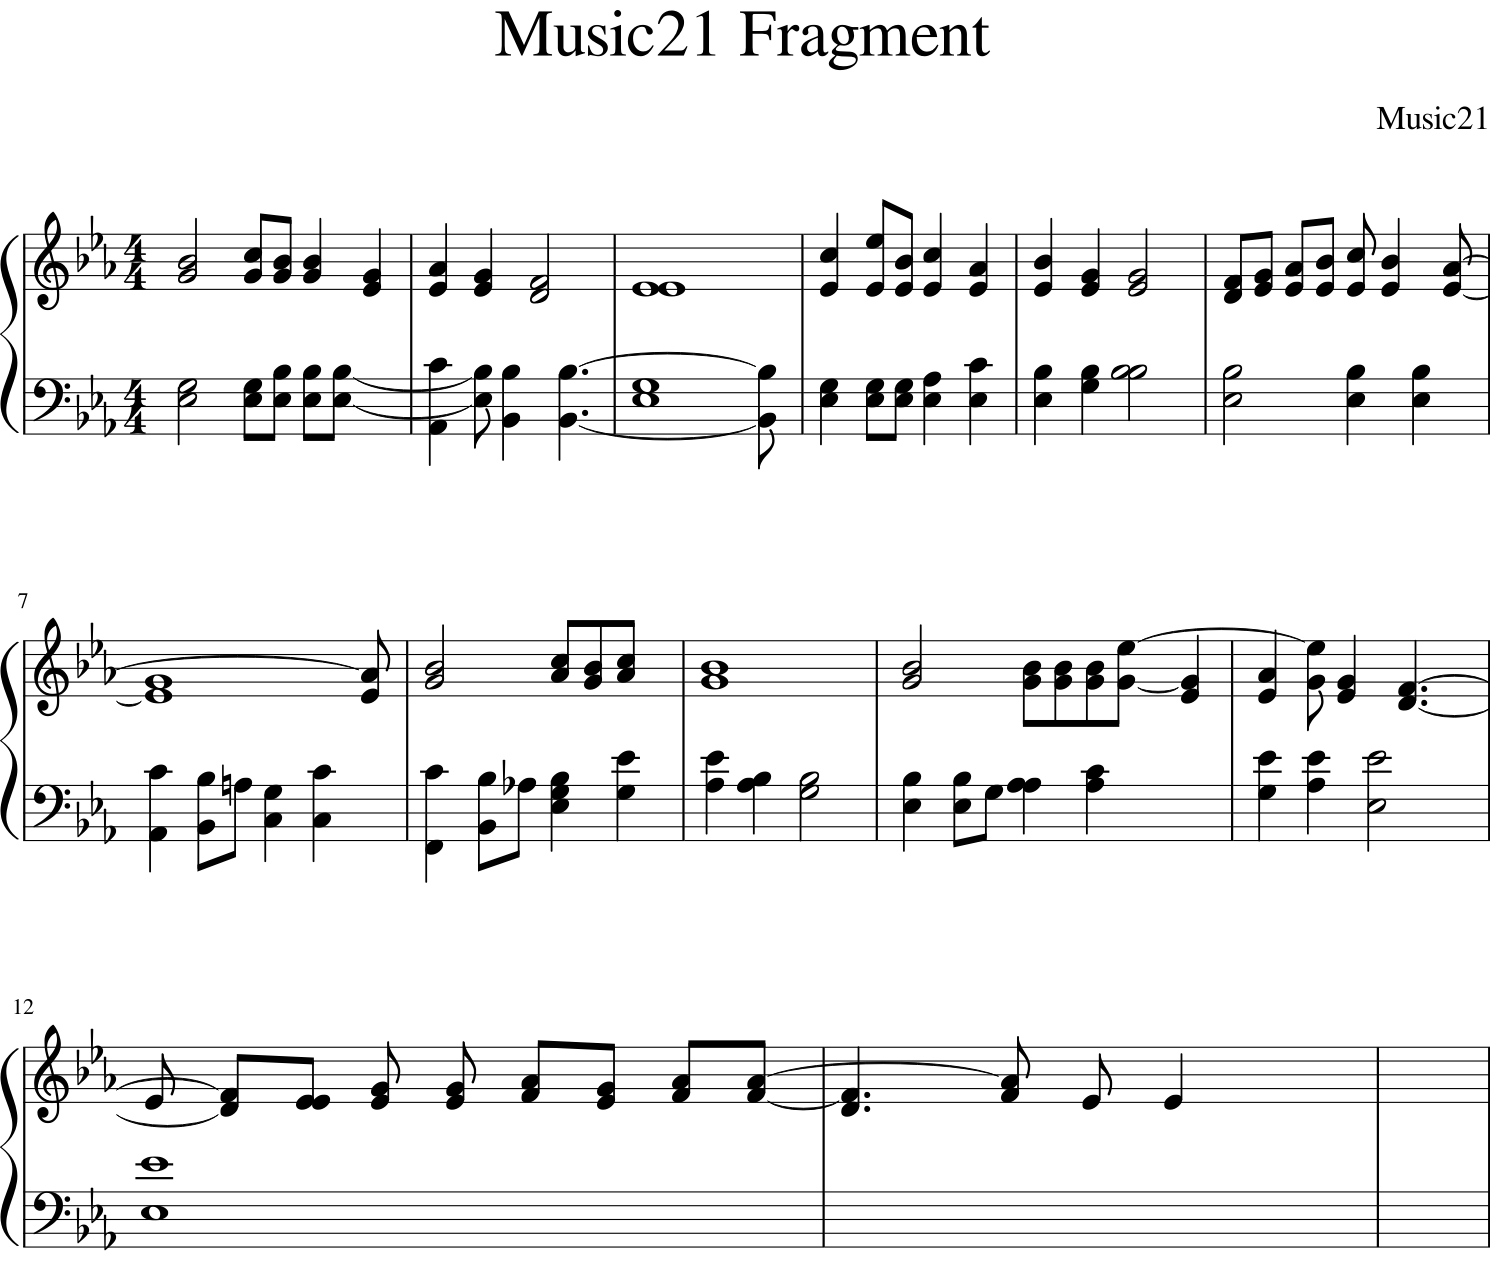

In [ ]:
display_and_play("/content/output.musicxml")

### Tentative 3

In [ ]:
def tok(prompt):
    return tok2id[prompt]

In [ ]:
prompt_right_hand = [
    'R', 'bar', 'key_flat_1', 'time_3/4', 'clef_treble',
    'note_C5', 'note_F4', 'len_1', 'note_C5', 'note_F4', 'len_1',
    'note_D5', 'note_F4', 'len_1',
    'bar', 'note_C5', 'note_F4', 'len_1', 'note_A4', 'note_F4', 'len_1',
    'note_G4', 'note_E4', 'len_1',
    'bar', 'note_F4', 'len_1', 'note_G4', 'note_F4', 'len_1',
    'note_G4', 'note_E4', 'len_1',
    'bar', 'note_A4', 'note_F4', 'len_3',
    'bar', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1',
    'note_F4', 'len_1',
    'bar', 'note_G4', 'note_C5', 'len_1', 'note_E4', 'len_1',
    'rest', 'len_1/2', 'note_Bb4', 'note_A4', 'note_F4', 'len_1/2',
    'bar', 'note_G4', 'note_D4', 'len_1', 'note_A4', 'note_C4', 'len_1',
    'note_A3', 'note_F4', 'len_1/2', 'note_B3', 'len_1/2',
    'bar', 'note_C4', 'note_A4', 'len_1', 'note_G4', 'len_2',
    'bar', 'note_C4', 'len_1', 'note_F4', 'note_C4', 'len_1',
    'note_A4', 'note_C4', 'len_1',
    'bar', 'note_C5', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1',
    'note_G4', 'note_C4', 'len_1',
    'bar', 'note_F4', 'note_D4', 'len_1', 'note_Bb4', 'note_D4', 'len_1',
    'note_C5', 'note_F4', 'len_1',
    'bar', 'note_D5', 'note_F4', 'len_3',
    'bar', 'note_D5', 'note_F4', 'len_1', 'note_D5', 'note_F4', 'len_1',
    'note_C5', 'note_E4', 'len_1',
    'bar', 'note_F4', 'len_1', 'note_Bb4', 'note_G4', 'len_1',
    'note_A4', 'note_F4', 'len_1',
    'bar', 'note_G4', 'note_D4', 'len_1', 'note_F4', 'note_C4', 'len_1',
    'note_E4', 'note_C4', 'len_1',
    'bar', 'note_F4', 'note_C4', 'len_3',
    'L', 'bar', 'key_flat_1', 'time_3/4', 'clef_bass'
]

In [ ]:
primer_ids = [tok(t) for t in prompt_right_hand if t in tok2id]
primer_ids = [BOS_TOKEN_ID] + primer_ids

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([primer_ids], dtype=torch.long, device=device)
    for _ in range(300):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 8
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

Generated ids: [2, 60, 6, 76, 69, 53, 19, 11, 4, 19, 11, 4, 24, 11, 4, 6, 19, 11, 4, 14, 11, 4, 9, 15, 4, 6, 11, 4, 9, 11, 4, 9, 15, 4, 6, 14, 11, 36, 6, 14, 11, 4, 9, 15, 4, 11, 4, 6, 9, 19, 4, 15, 4, 21, 5, 23, 14, 11, 5, 6, 9, 7, 4, 14, 10, 4, 16, 11, 5, 27, 5, 6, 10, 14, 4, 9, 13, 6, 10, 4, 11, 10, 4, 14, 10, 4, 6, 19, 10, 4, 14, 10, 4, 9, 10, 4, 6, 11, 7, 4, 23, 7, 4, 19, 11, 4, 6, 24, 11, 36, 6, 24, 11, 4, 24, 11, 4, 19, 15, 4, 6, 11, 4, 23, 9, 4, 14, 11, 4, 6, 9, 7, 4, 11, 10, 4, 15, 10, 4, 6, 11, 10, 36, 59, 6, 76, 69, 55, 10, 20, 4, 16, 20, 4, 10, 16, 4, 6, 7, 22, 4, 10, 34, 4, 10, 20, 4, 6, 18, 33, 4, 16, 25, 4, 12, 25, 4, 6, 16, 63, 36, 6, 10, 20, 4, 10, 20, 4, 18, 25, 4, 6, 16, 63, 4, 10, 38, 4, 10, 25, 4, 6, 16, 22, 4, 12, 33, 4, 12, 47, 4, 6, 25, 12, 4, 20, 4, 34, 25, 4, 6, 16, 20, 36, 6, 10, 25, 4, 10, 25, 4, 10, 25, 4, 6, 16, 20, 4, 7, 22, 4, 10, 34, 4, 6, 10, 20, 4, 18, 12, 4, 10, 16, 4, 6, 10, 18, 4, 7, 12, 4, 12, 25, 4, 6, 16, 20, 36]


In [ ]:
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_flat_1', 'time_3/4', 'clef_treble', 'note_C5', 'note_F4', 'len_1', 'note_C5', 'note_F4', 'len_1', 'note_D5', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_F4', 'len_1', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'bar', 'note_F4', 'len_1', 'note_G4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'bar', 'note_A4', 'note_F4', 'len_3', 'bar', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_C5', 'len_1', 'note_E4', 'len_1', 'rest', 'len_1/2', 'note_Bb4', 'note_A4', 'note_F4', 'len_1/2', 'bar', 'note_G4', 'note_D4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'note_A3', 'note_F4', 'len_1/2', 'note_B3', 'len_1/2', 'bar', 'note_C4', 'note_A4', 'len_1', 'note_G4', 'len_2', 'bar', 'note_C4', 'len_1', 'note_F4', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'note_G4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_D4', 'len_1'

In [ ]:
score = convert_tokens_to_musicxml(tokens,"output.musicxml")

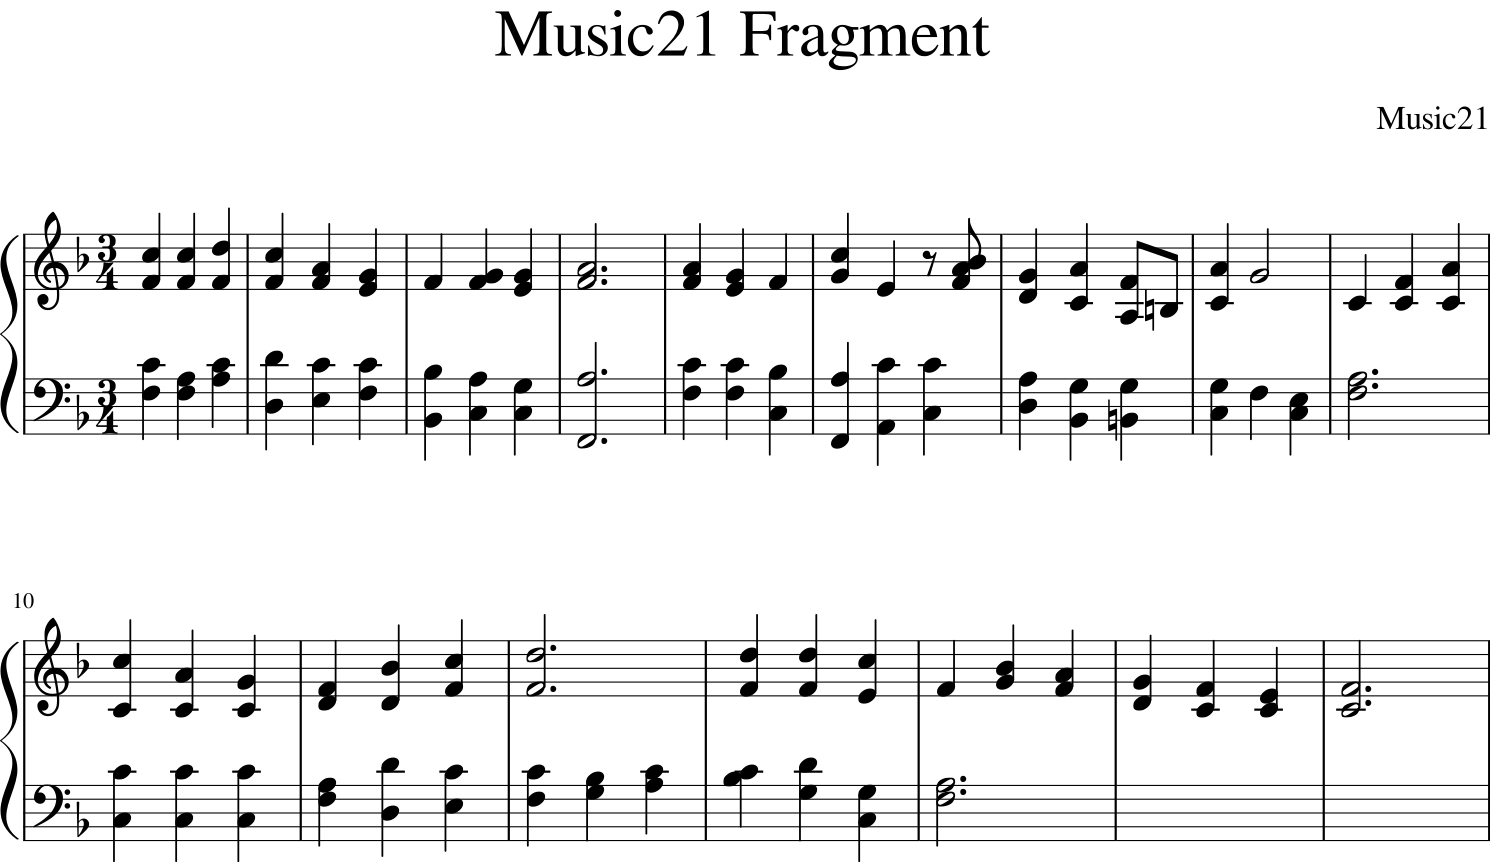

In [ ]:
display_and_play("/content/output.musicxml")

J'ai generé une deuxieme fois avec les meme parametre pour voir si ca changeait beaucoup, et voici le résultat :

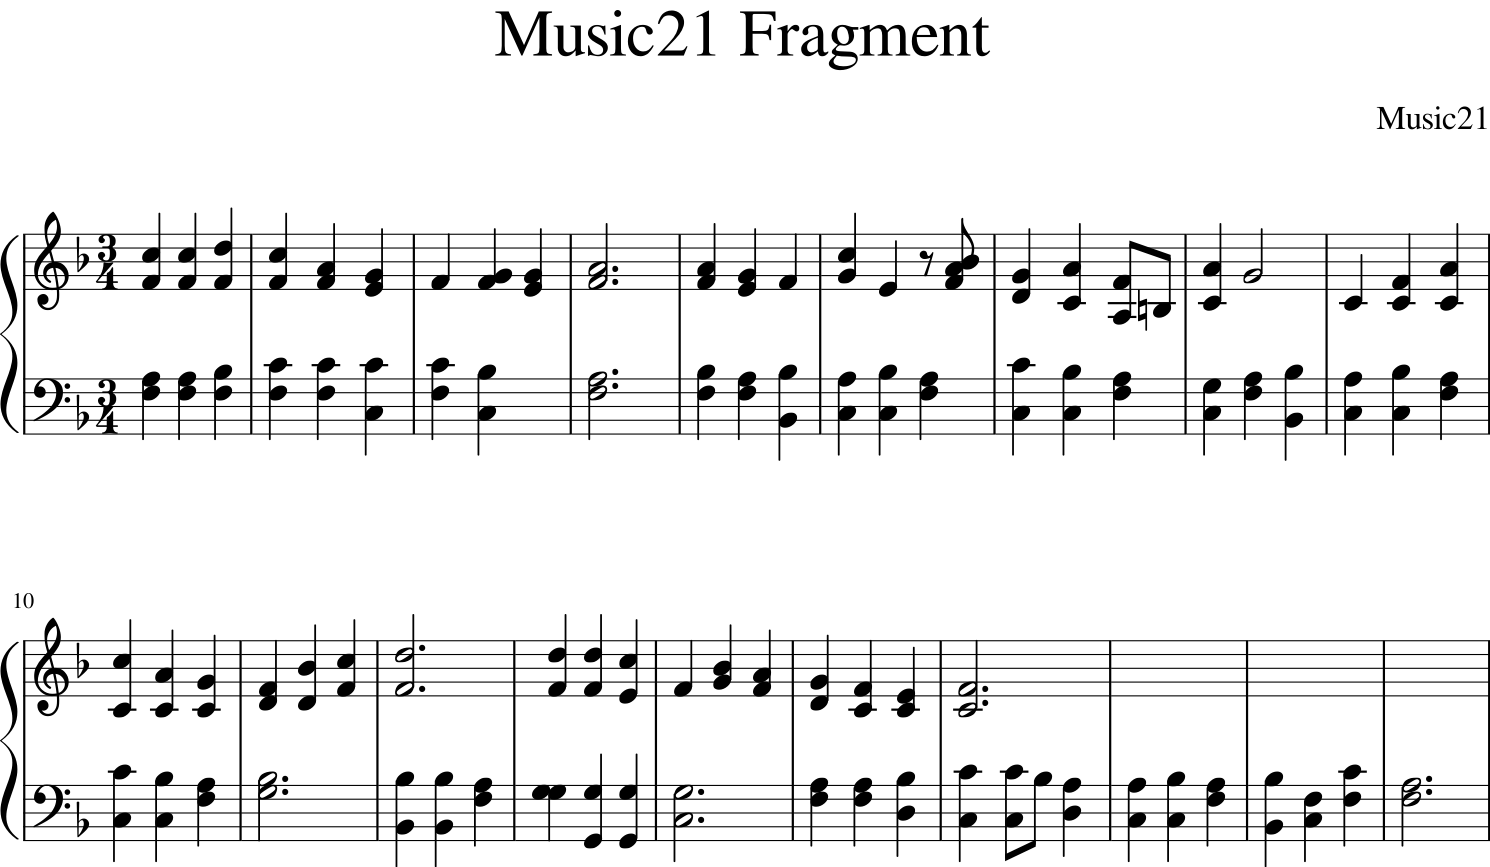

In [ ]:
display_and_play("/content/output.musicxml")

top_k=40

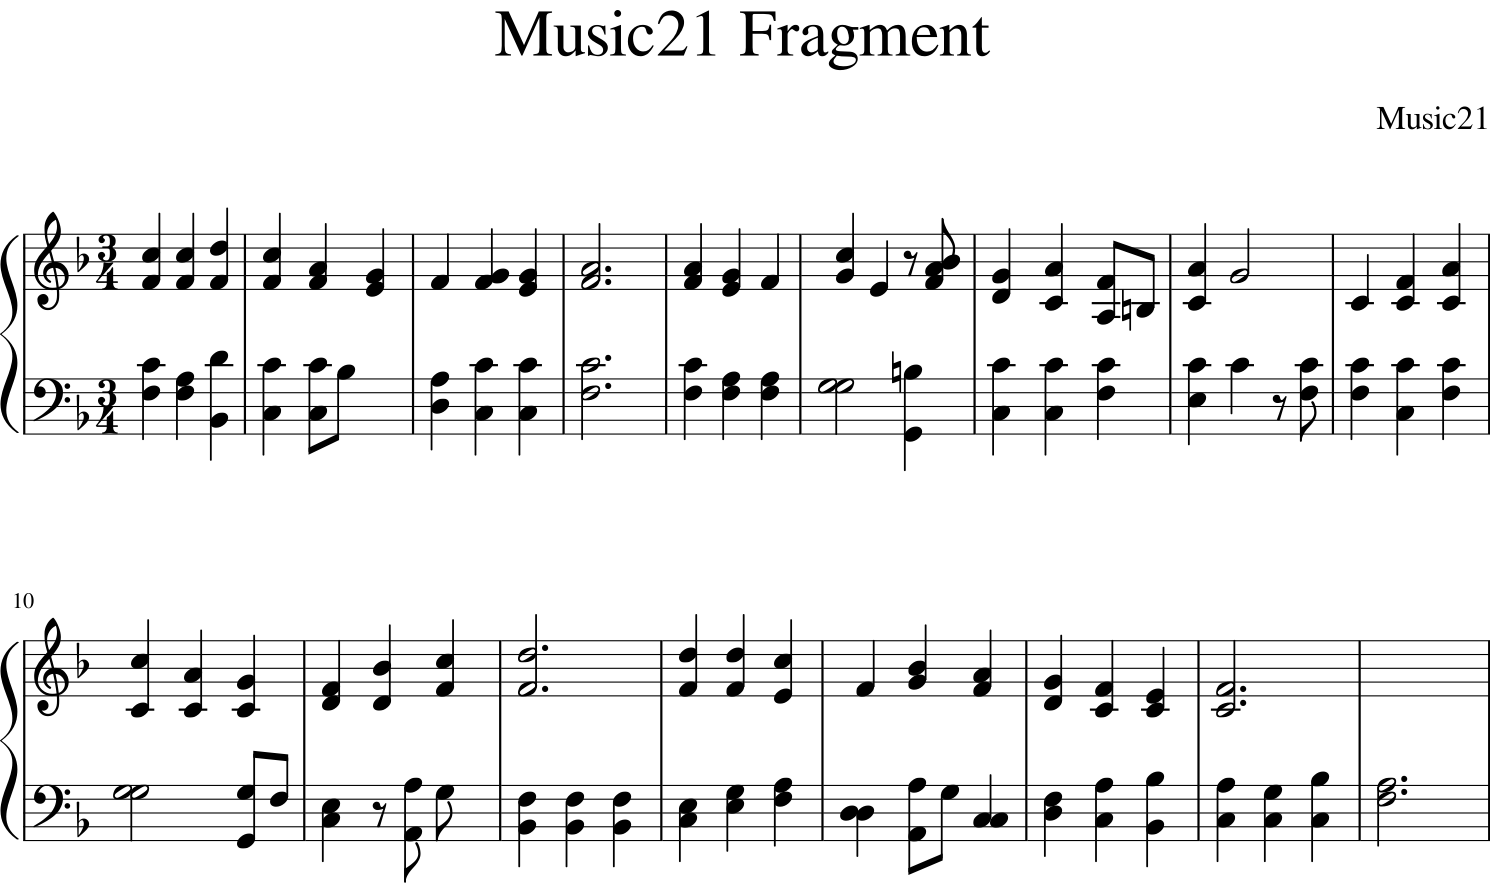

In [ ]:
display_and_play("/content/output.musicxml")

### Tentative 4

Je genere, à partir des trois premiere mesure d'un morceau de Bach, tout le main droite jusqu'a L. En suite je donne en prompt cette main droite generé et je genere la main gauche

In [ ]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_simplify /content/data/

In [ ]:
def tok(prompt):
    return tok2id[prompt]

In [ ]:
# chemin du fichier
partition_Bach = "/content/data/QmWtmdgRHpAfkEhet1VrX1ZDpqGFGMDCd8y2BsFzL3yAXj.txt"

# lire le contenu du fichier
with open(partition_Bach, "r") as f:
    content = f.read().strip()

# découper le contenu en tokens (séparés par des espaces)
tokens = content.split()

print(tokens[:50])  # afficher les 50 premiers pour vérifier
print(len(tokens), "tokens chargés")


['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_G5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_E5']
670 tokens chargés


In [ ]:
partition_original = convert_tokens_to_musicxml(tokens,"partition_Bach.musicxml")

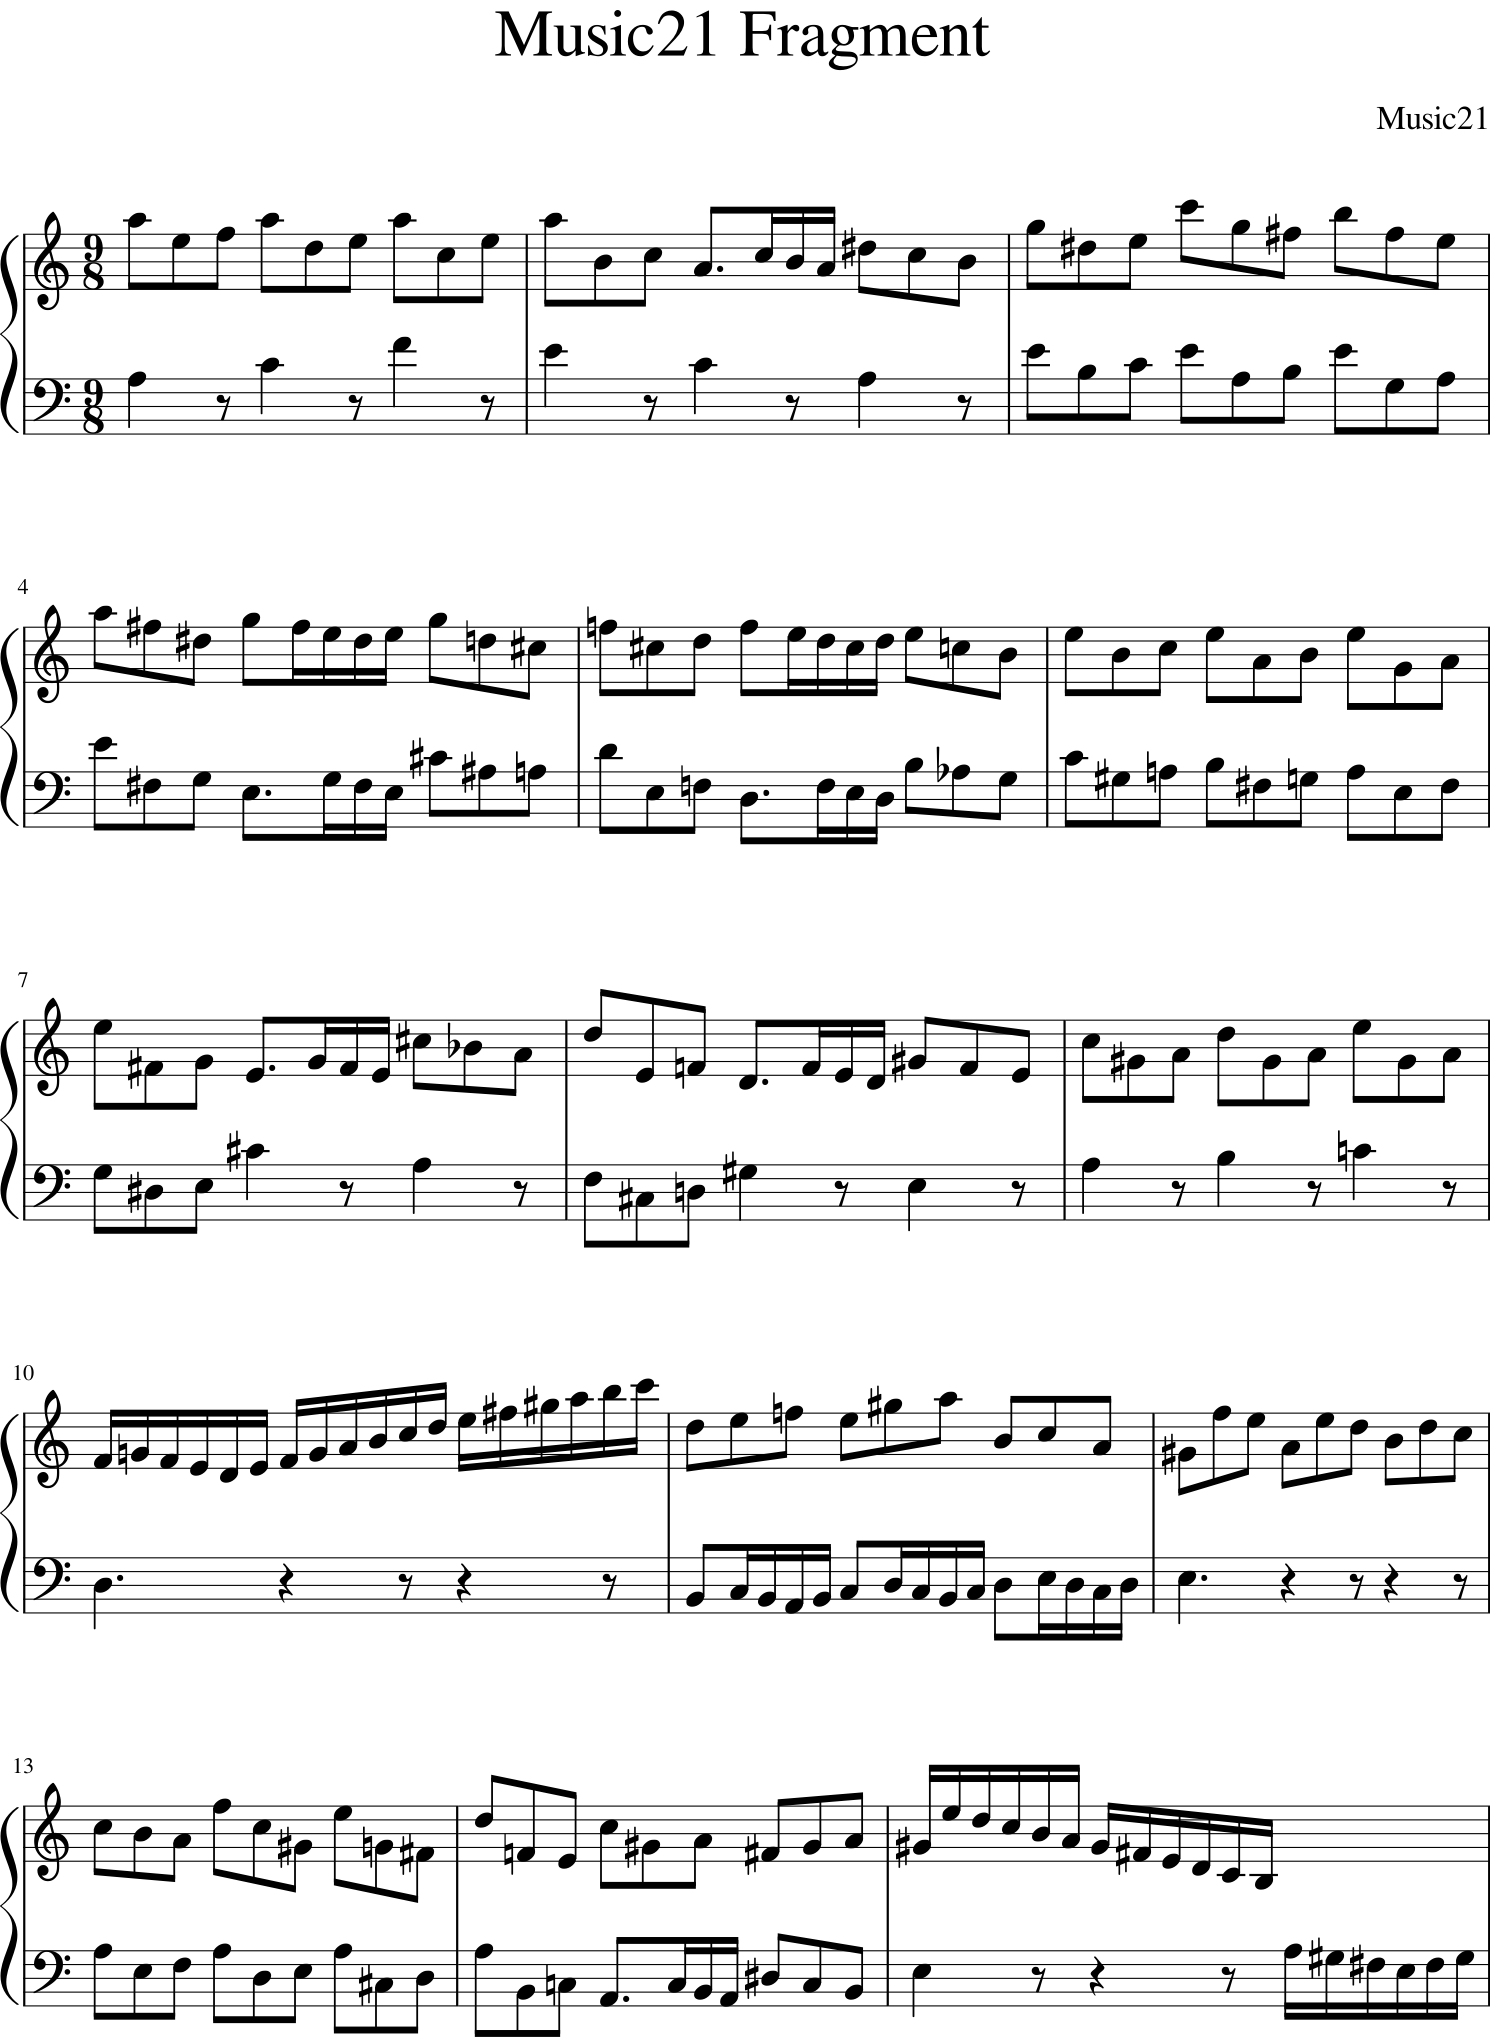

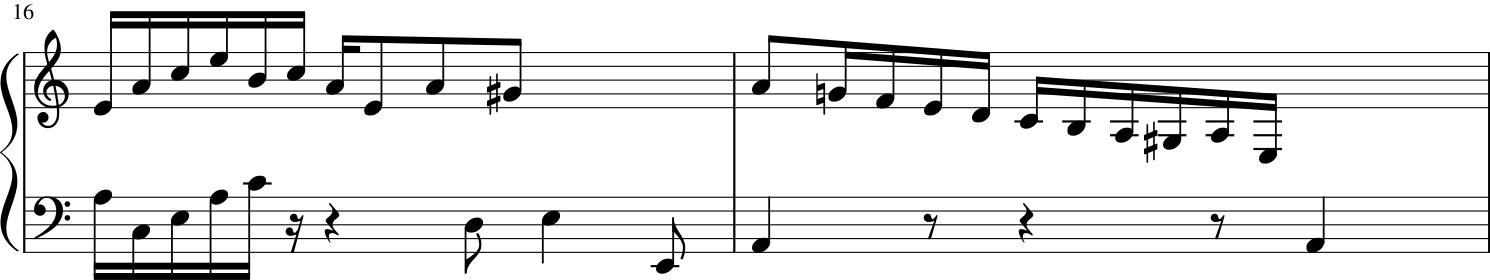

In [ ]:
display_and_play("/content/partition_Bach.musicxml")

In [ ]:
tokens_all = ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble',
 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2',
 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2',
 'bar', 'note_G5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_E5', 'len_1/2', 'note_C6', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_B5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_E5', 'len_1/2',
 'bar', 'note_A5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_D#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_G5', 'len_1/2', 'note_D5', 'len_1/2', 'note_C#5', 'len_1/2',
 'bar', 'note_F5', 'len_1/2', 'note_C#5', 'len_1/2', 'note_D5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/4', 'note_D5', 'len_1/4', 'note_C#5', 'len_1/4', 'note_D5', 'len_1/4', 'note_E5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2',
 'bar', 'note_E5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A4', 'len_1/2', 'note_B4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_E5', 'len_1/2', 'note_F#4', 'len_1/2', 'note_G4', 'len_1/2', 'note_E4', 'len_3/4', 'note_G4', 'len_1/4', 'note_F#4', 'len_1/4', 'note_E4', 'len_1/4', 'note_C#5', 'len_1/2', 'note_Bb4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_D5', 'len_1/2', 'note_E4', 'len_1/2', 'note_F4', 'len_1/2', 'note_D4', 'len_3/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_G#4', 'len_1/2', 'note_F4', 'len_1/2', 'note_E4', 'len_1/2',
 'bar', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_D5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_F4', 'len_1/4', 'note_G4', 'len_1/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_E4', 'len_1/4', 'note_F4', 'len_1/4', 'note_G4', 'len_1/4', 'note_A4', 'len_1/4', 'note_B4', 'len_1/4', 'note_C5', 'len_1/4', 'note_D5', 'len_1/4', 'note_E5', 'len_1/4', 'note_F#5', 'len_1/4', 'note_G#5', 'len_1/4', 'note_A5', 'len_1/4', 'note_B5', 'len_1/4', 'note_C6', 'len_1/4',
 'bar', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_G#5', 'len_1/2', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_G#4', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A4', 'len_1/2', 'note_E5', 'len_1/2', 'note_D5', 'len_1/2', 'note_B4', 'len_1/2', 'note_D5', 'len_1/2', 'note_C5', 'len_1/2',
 'bar', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'note_A4', 'len_1/2', 'note_F5', 'len_1/2', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G4', 'len_1/2', 'note_F#4', 'len_1/2',
 'bar', 'note_D5', 'len_1/2', 'note_F4', 'len_1/2', 'note_E4', 'len_1/2', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_F#4', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_G#4', 'len_1/4', 'note_E5', 'len_1/4', 'note_D5', 'len_1/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_G#4', 'len_1/4', 'note_F#4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_C4', 'len_1/4', 'note_B3', 'len_1/4',
 'bar', 'note_E4', 'len_1/4', 'note_A4', 'len_1/4', 'note_C5', 'len_1/4', 'note_E5', 'len_1/4', 'note_B4', 'len_1/4', 'note_C5', 'len_1/4', 'note_A4', 'len_1/4', 'note_E4', 'len_1/2', 'note_A4', 'len_1/2', 'note_G#4', 'len_1/2',
 'bar', 'note_A4', 'len_1/2', 'note_G4', 'len_1/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_C4', 'len_1/4', 'note_B3', 'len_1/4', 'note_A3', 'len_1/4', 'note_G#3', 'len_1/4', 'note_A3', 'len_1/4', 'note_E3', 'len_1/4',
 'L', 'bar', 'key_natural_0', 'time_9/8', 'clef_bass',
 'note_A3', 'len_1', 'rest', 'len_1/2', 'note_C4', 'len_1', 'rest', 'len_1/2', 'note_F4', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_E4', 'len_1', 'rest', 'len_1/2', 'note_C4', 'len_1', 'rest', 'len_1/2', 'note_A3', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_E4', 'len_1/2', 'note_B3', 'len_1/2', 'note_C4', 'len_1/2', 'note_E4', 'len_1/2', 'note_A3', 'len_1/2', 'note_B3', 'len_1/2', 'note_E4', 'len_1/2', 'note_G3', 'len_1/2', 'note_A3', 'len_1/2',
 'bar', 'note_E4', 'len_1/2', 'note_F#3', 'len_1/2', 'note_G3', 'len_1/2', 'note_E3', 'len_3/4', 'note_G3', 'len_1/4', 'note_F#3', 'len_1/4', 'note_E3', 'len_1/4', 'note_C#4', 'len_1/2', 'note_A#3', 'len_1/2', 'note_A3', 'len_1/2',
 'bar', 'note_D4', 'len_1/2', 'note_E3', 'len_1/2', 'note_F3', 'len_1/2', 'note_D3', 'len_3/4', 'note_F3', 'len_1/4', 'note_E3', 'len_1/4', 'note_D3', 'len_1/4', 'note_B3', 'len_1/2', 'note_Ab3', 'len_1/2', 'note_G3', 'len_1/2',
 'bar', 'note_C4', 'len_1/2', 'note_G#3', 'len_1/2', 'note_A3', 'len_1/2', 'note_B3', 'len_1/2', 'note_F#3', 'len_1/2', 'note_G3', 'len_1/2', 'note_A3', 'len_1/2', 'note_E3', 'len_1/2', 'note_F#3', 'len_1/2',
 'bar', 'note_G3', 'len_1/2', 'note_D#3', 'len_1/2', 'note_E3', 'len_1/2', 'note_C#4', 'len_1', 'rest', 'len_1/2', 'note_A3', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_F3', 'len_1/2', 'note_C#3', 'len_1/2', 'note_D3', 'len_1/2', 'note_G#3', 'len_1', 'rest', 'len_1/2', 'note_E3', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_A3', 'len_1', 'rest', 'len_1/2', 'note_B3', 'len_1', 'rest', 'len_1/2', 'note_C4', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_D3', 'len_3/2', 'rest', 'len_1', 'rest', 'len_1/2', 'rest', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_B2', 'len_1/2', 'note_C3', 'len_1/4', 'note_B2', 'len_1/4', 'note_A2', 'len_1/4', 'note_B2', 'len_1/4', 'note_C3', 'len_1/2', 'note_D3', 'len_1/4', 'note_C3', 'len_1/4', 'note_B2', 'len_1/4', 'note_C3', 'len_1/4', 'note_D3', 'len_1/2', 'note_E3', 'len_1/4', 'note_D3', 'len_1/4', 'note_C3', 'len_1/4', 'note_D3', 'len_1/4',
 'bar', 'note_E3', 'len_3/2', 'rest', 'len_1', 'rest', 'len_1/2', 'rest', 'len_1', 'rest', 'len_1/2',
 'bar', 'note_A3', 'len_1/2', 'note_E3', 'len_1/2', 'note_F3', 'len_1/2', 'note_A3', 'len_1/2', 'note_D3', 'len_1/2', 'note_E3', 'len_1/2', 'note_A3', 'len_1/2', 'note_C#3', 'len_1/2', 'note_D3', 'len_1/2',
 'bar', 'note_A3', 'len_1/2', 'note_B2', 'len_1/2', 'note_C3', 'len_1/2', 'note_A2', 'len_3/4', 'note_C3', 'len_1/4', 'note_B2', 'len_1/4', 'note_A2', 'len_1/4', 'note_D#3', 'len_1/2', 'note_C3', 'len_1/2', 'note_B2', 'len_1/2',
 'bar', 'note_E3', 'len_1', 'rest', 'len_1/2', 'rest', 'len_1', 'rest', 'len_1/2', 'note_A3', 'len_1/4', 'note_G#3', 'len_1/4', 'note_F#3', 'len_1/4', 'note_E3', 'len_1/4', 'note_F#3', 'len_1/4', 'note_G#3', 'len_1/4',
 'bar', 'note_A3', 'len_1/4', 'note_C3', 'len_1/4', 'note_E3', 'len_1/4', 'note_A3', 'len_1/4', 'note_C4', 'len_1/4', 'rest', 'len_1/4', 'rest', 'len_1', 'note_D3', 'len_1/2', 'note_E3', 'len_1', 'note_E2', 'len_1/2',
 'bar', 'note_A2', 'len_1', 'rest', 'len_1/2', 'rest', 'len_1', 'rest', 'len_1/2', 'note_A2', 'len_1'
 ]

In [ ]:
right_hand_begining= ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble',
 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2',
 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2',
 'bar'
]

In [ ]:
primer_ids = [tok(t) for t in right_hand_begining if t in tok2id]
primer_ids = [BOS_TOKEN_ID] + primer_ids

In [ ]:
# id of 'L' (left-hand marker) to stop RH generation
L_ID = tok2id['L']  # raises KeyError if missing -> good to fail loudly

device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([primer_ids], dtype=torch.long, device=device)
    max_new_tokens = 670
    for _ in range(max_new_tokens):
        logits = model(input_ids).logits[:, -1, :]

        # top-k sampling (same as you had)
        top_k = 40
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()

        # stop when 'L' appears (include it in the output so the stream stays R ... L ...)
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)
        if next_id == L_ID:
            break

generated = input_ids[0].tolist()
print("Generated ids:", generated)


Generated ids: [2, 60, 6, 84, 133, 53, 57, 5, 37, 5, 49, 5, 57, 5, 24, 5, 37, 5, 57, 5, 19, 5, 37, 5, 6, 57, 5, 28, 5, 19, 5, 14, 32, 19, 8, 28, 8, 14, 8, 75, 5, 19, 5, 28, 5, 6, 37, 5, 28, 5, 24, 5, 19, 26, 37, 4, 24, 5, 6, 79, 5, 68, 5, 57, 5, 52, 5, 49, 5, 37, 5, 24, 5, 37, 5, 151, 5, 49, 5, 37, 5, 6, 94, 5, 79, 5, 70, 5, 68, 5, 57, 5, 52, 5, 24, 5, 52, 5, 58, 4, 21, 5, 6, 15, 5, 37, 5, 58, 5, 37, 5, 58, 5, 37, 5, 75, 5, 6, 37, 5, 37, 5, 49, 5, 52, 5, 49, 5, 37, 5, 24, 45, 37, 45, 49, 45, 24, 45, 49, 45, 6, 12, 5, 24, 5, 28, 5, 9, 5, 15, 5, 14, 5, 19, 27, 5, 10, 5, 6, 11, 5, 14, 5, 14, 5, 24, 5, 37, 5, 49, 5, 52, 5, 57, 5, 57, 5, 19, 5, 37, 5, 49, 5, 6, 57, 5, 37, 5, 24, 5, 19, 5, 37, 5, 49, 5, 57, 5, 37, 5, 24, 5, 49, 5, 37, 5, 6, 19, 5, 24, 5, 19, 5, 28, 5, 37, 19, 5, 58, 5, 52, 5, 6, 57, 5, 24, 5, 68, 5, 57, 5, 24, 5, 52, 5, 58, 5, 6, 24, 5, 28, 5, 9, 5, 15, 5, 10, 5, 27, 5, 70, 5, 57, 5, 49, 5, 37, 5, 6, 24, 5, 28, 5, 9, 5, 15, 5, 14, 5, 19, 27, 5, 7, 27, 5, 6, 11, 7, 5, 15, 10,

In [ ]:
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_E5', 'len_1/2', 'note_B4', 'len_1/2', 'note_D5', 'len_1/2', 'note_C5', 'len_3/2', 'note_E5', 'len_1', 'note_D5', 'len_1/2', 'bar', 'note_D6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F##5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_E6', 'len_1/2', 'note_D6', 'len_1/2', 'note_C6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'not

In [ ]:
right_hand = tokens + ['bar', 'key_natural_0', 'time_9/8', 'clef_bass']
print(right_hand)

['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_E5', 'len_1/2', 'note_B4', 'len_1/2', 'note_D5', 'len_1/2', 'note_C5', 'len_3/2', 'note_E5', 'len_1', 'note_D5', 'len_1/2', 'bar', 'note_D6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F##5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_E6', 'len_1/2', 'note_D6', 'len_1/2', 'note_C6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'note_G5', '

In [ ]:
right_hand_ids = [tok(t) for t in right_hand if t in tok2id]
right_hand_ids = [BOS_TOKEN_ID] + right_hand_ids

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([right_hand_ids], dtype=torch.long, device=device)
    for _ in range(345):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 40
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

Generated ids: [2, 60, 6, 84, 133, 53, 57, 5, 37, 5, 49, 5, 57, 5, 24, 5, 37, 5, 57, 5, 19, 5, 37, 5, 6, 57, 5, 28, 5, 19, 5, 14, 32, 19, 8, 28, 8, 14, 8, 75, 5, 19, 5, 28, 5, 6, 37, 5, 28, 5, 24, 5, 19, 26, 37, 4, 24, 5, 6, 79, 5, 68, 5, 57, 5, 52, 5, 49, 5, 37, 5, 24, 5, 37, 5, 151, 5, 49, 5, 37, 5, 6, 94, 5, 79, 5, 70, 5, 68, 5, 57, 5, 52, 5, 24, 5, 52, 5, 58, 4, 21, 5, 6, 15, 5, 37, 5, 58, 5, 37, 5, 58, 5, 37, 5, 75, 5, 6, 37, 5, 37, 5, 49, 5, 52, 5, 49, 5, 37, 5, 24, 45, 37, 45, 49, 45, 24, 45, 49, 45, 6, 12, 5, 24, 5, 28, 5, 9, 5, 15, 5, 14, 5, 19, 27, 5, 10, 5, 6, 11, 5, 14, 5, 14, 5, 24, 5, 37, 5, 49, 5, 52, 5, 57, 5, 57, 5, 19, 5, 37, 5, 49, 5, 6, 57, 5, 37, 5, 24, 5, 19, 5, 37, 5, 49, 5, 57, 5, 37, 5, 24, 5, 49, 5, 37, 5, 6, 19, 5, 24, 5, 19, 5, 28, 5, 37, 19, 5, 58, 5, 52, 5, 6, 57, 5, 24, 5, 68, 5, 57, 5, 24, 5, 52, 5, 58, 5, 6, 24, 5, 28, 5, 9, 5, 15, 5, 10, 5, 27, 5, 70, 5, 57, 5, 49, 5, 37, 5, 6, 24, 5, 28, 5, 9, 5, 15, 5, 14, 5, 19, 27, 5, 7, 27, 5, 6, 11, 7, 5, 15, 10,

In [ ]:
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_E5', 'len_1/2', 'note_B4', 'len_1/2', 'note_D5', 'len_1/2', 'note_C5', 'len_3/2', 'note_E5', 'len_1', 'note_D5', 'len_1/2', 'bar', 'note_D6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F##5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_E6', 'len_1/2', 'note_D6', 'len_1/2', 'note_C6', 'len_1/2', 'note_B5', 'len_1/2', 'note_A5', 'len_1/2', 'not

In [ ]:
score = convert_tokens_to_musicxml(tokens,"output.musicxml")

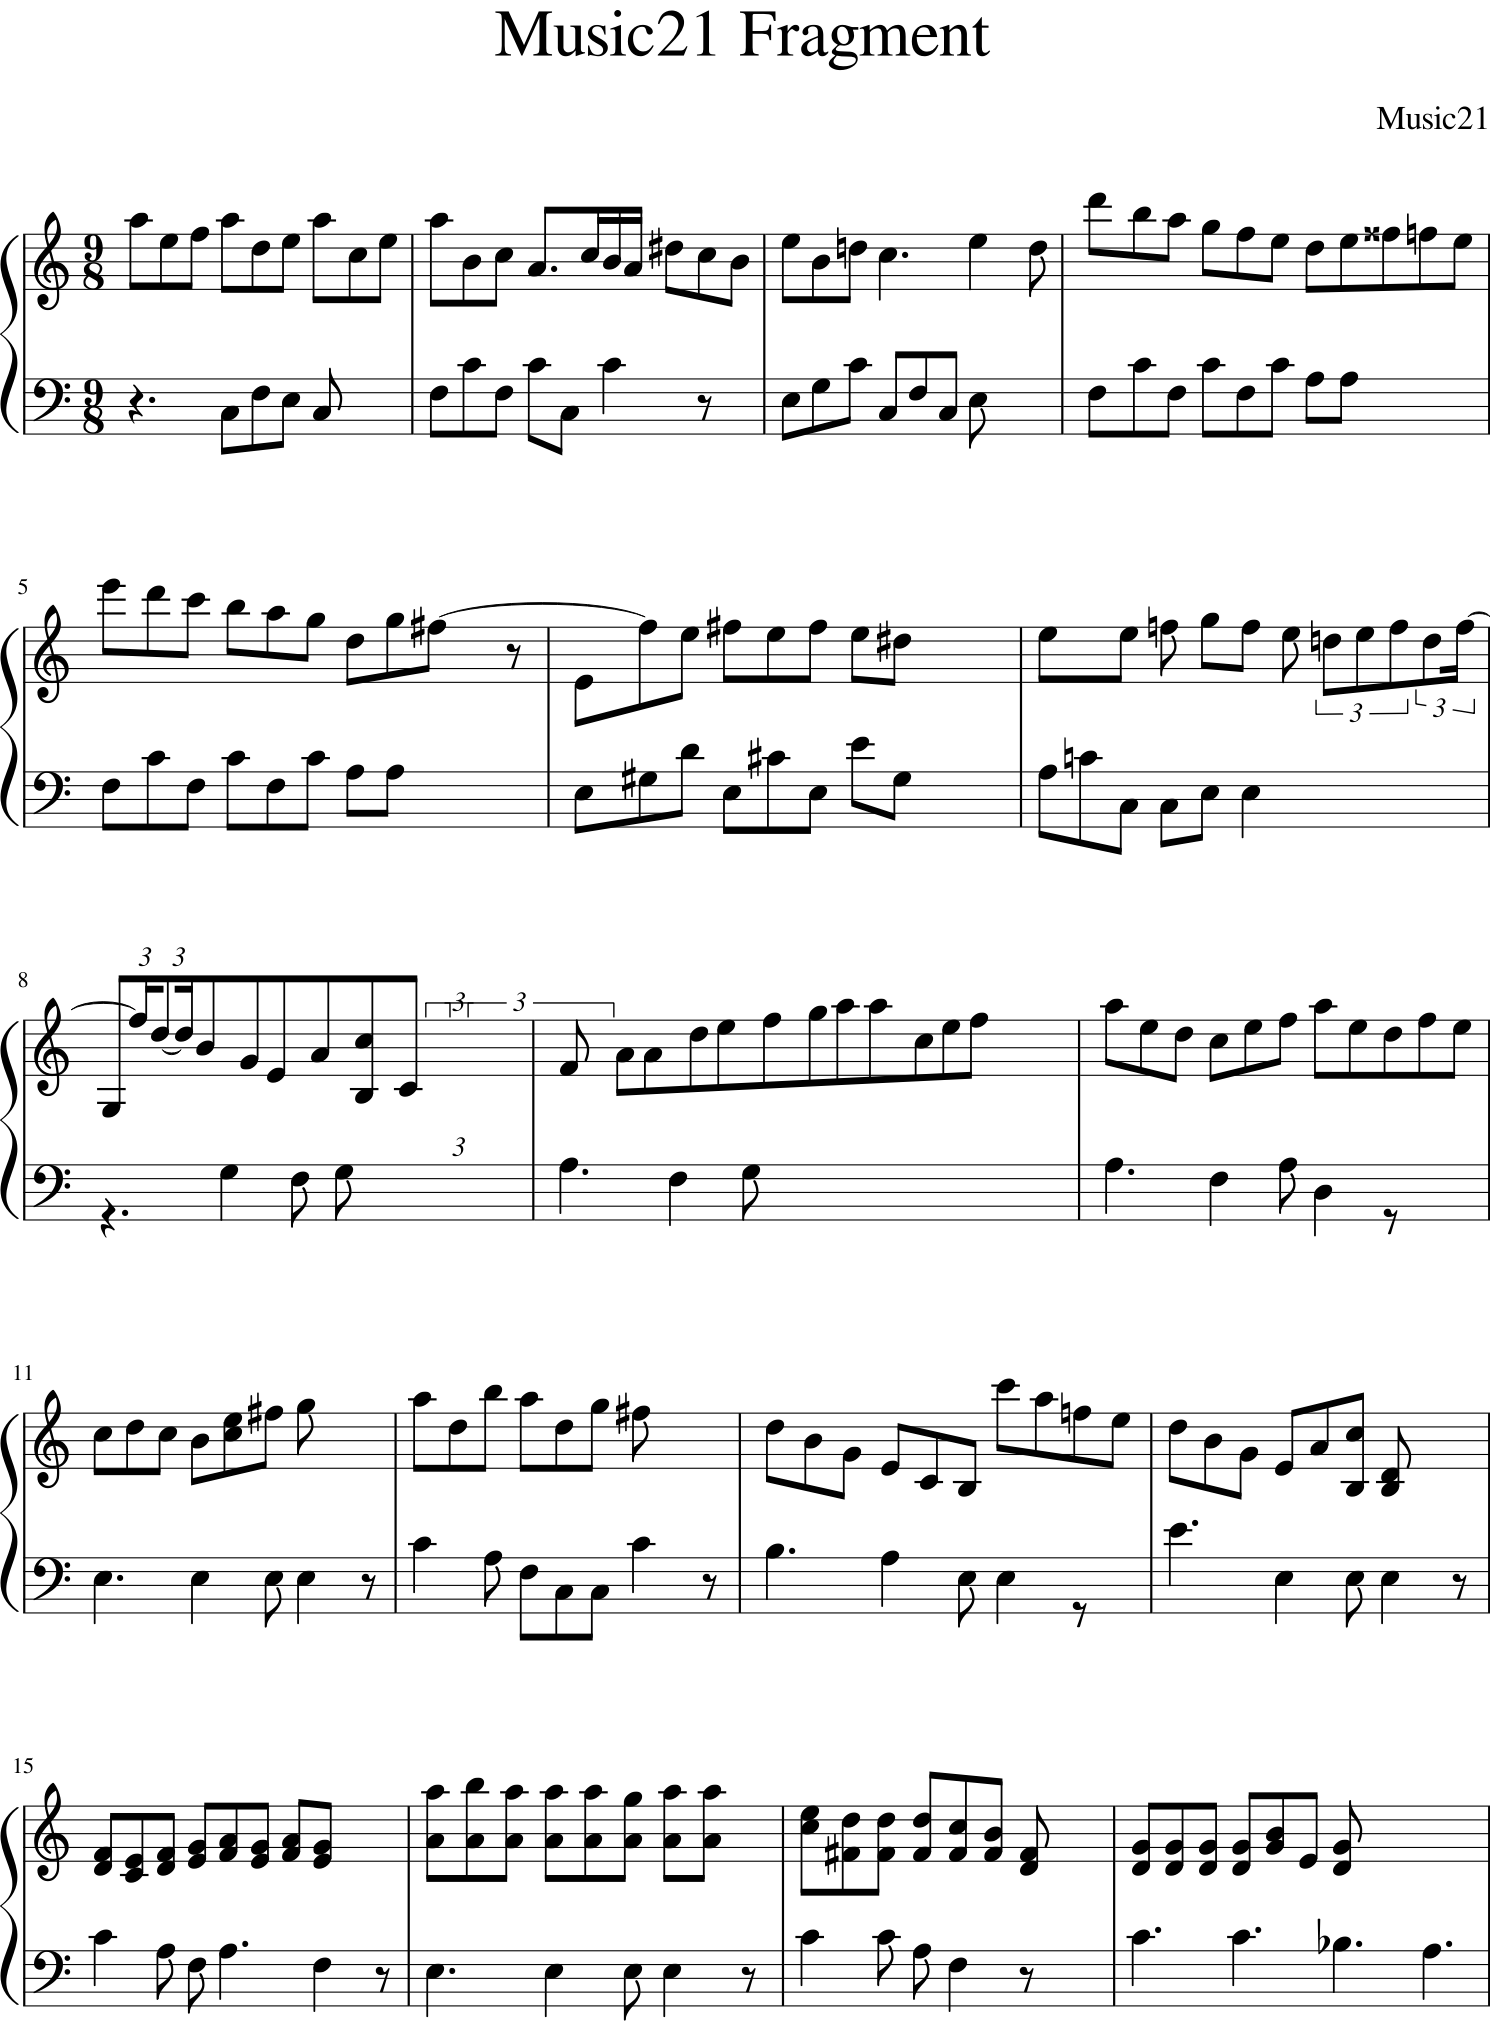

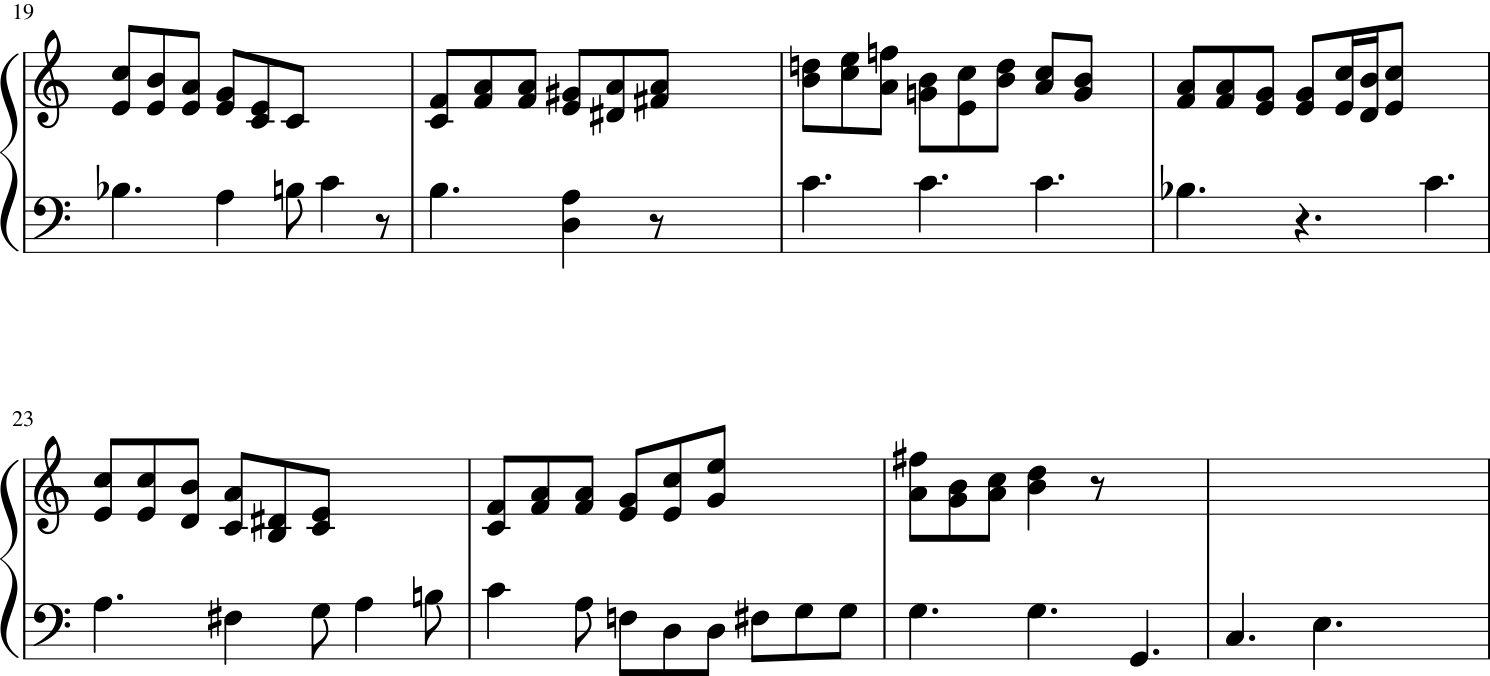

In [ ]:
display_and_play("/content/output.musicxml")

Là je genere la main gauche en lui donnant toute la vrai partie main droite, pour comparer avec la methode d'avant

In [ ]:
right_hand = ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble',
 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2',
 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2',
 'bar', 'note_G5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_E5', 'len_1/2', 'note_C6', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_B5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_E5', 'len_1/2',
 'bar', 'note_A5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_D#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_G5', 'len_1/2', 'note_D5', 'len_1/2', 'note_C#5', 'len_1/2',
 'bar', 'note_F5', 'len_1/2', 'note_C#5', 'len_1/2', 'note_D5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/4', 'note_D5', 'len_1/4', 'note_C#5', 'len_1/4', 'note_D5', 'len_1/4', 'note_E5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2',
 'bar', 'note_E5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A4', 'len_1/2', 'note_B4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_E5', 'len_1/2', 'note_F#4', 'len_1/2', 'note_G4', 'len_1/2', 'note_E4', 'len_3/4', 'note_G4', 'len_1/4', 'note_F#4', 'len_1/4', 'note_E4', 'len_1/4', 'note_C#5', 'len_1/2', 'note_Bb4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_D5', 'len_1/2', 'note_E4', 'len_1/2', 'note_F4', 'len_1/2', 'note_D4', 'len_3/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_G#4', 'len_1/2', 'note_F4', 'len_1/2', 'note_E4', 'len_1/2',
 'bar', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_D5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_F4', 'len_1/4', 'note_G4', 'len_1/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_E4', 'len_1/4', 'note_F4', 'len_1/4', 'note_G4', 'len_1/4', 'note_A4', 'len_1/4', 'note_B4', 'len_1/4', 'note_C5', 'len_1/4', 'note_D5', 'len_1/4', 'note_E5', 'len_1/4', 'note_F#5', 'len_1/4', 'note_G#5', 'len_1/4', 'note_A5', 'len_1/4', 'note_B5', 'len_1/4', 'note_C6', 'len_1/4',
 'bar', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_G#5', 'len_1/2', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_G#4', 'len_1/2', 'note_F5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A4', 'len_1/2', 'note_E5', 'len_1/2', 'note_D5', 'len_1/2', 'note_B4', 'len_1/2', 'note_D5', 'len_1/2', 'note_C5', 'len_1/2',
 'bar', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'note_A4', 'len_1/2', 'note_F5', 'len_1/2', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_E5', 'len_1/2', 'note_G4', 'len_1/2', 'note_F#4', 'len_1/2',
 'bar', 'note_D5', 'len_1/2', 'note_F4', 'len_1/2', 'note_E4', 'len_1/2', 'note_C5', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2', 'note_F#4', 'len_1/2', 'note_G#4', 'len_1/2', 'note_A4', 'len_1/2',
 'bar', 'note_G#4', 'len_1/4', 'note_E5', 'len_1/4', 'note_D5', 'len_1/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_G#4', 'len_1/4', 'note_F#4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_C4', 'len_1/4', 'note_B3', 'len_1/4',
 'bar', 'note_E4', 'len_1/4', 'note_A4', 'len_1/4', 'note_C5', 'len_1/4', 'note_E5', 'len_1/4', 'note_B4', 'len_1/4', 'note_C5', 'len_1/4', 'note_A4', 'len_1/4', 'note_E4', 'len_1/2', 'note_A4', 'len_1/2', 'note_G#4', 'len_1/2',
 'bar', 'note_A4', 'len_1/2', 'note_G4', 'len_1/4', 'note_F4', 'len_1/4', 'note_E4', 'len_1/4', 'note_D4', 'len_1/4', 'note_C4', 'len_1/4', 'note_B3', 'len_1/4', 'note_A3', 'len_1/4', 'note_G#3', 'len_1/4', 'note_A3', 'len_1/4', 'note_E3', 'len_1/4',
 'L', 'bar', 'key_natural_0', 'time_9/8', 'clef_bass'
 ]

In [ ]:
right_hand_ids = [tok(t) for t in right_hand if t in tok2id]
right_hand_ids = [BOS_TOKEN_ID] + right_hand_ids

In [ ]:
device = next(model.parameters()).device
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([right_hand_ids], dtype=torch.long, device=device)
    for _ in range(345):  # génère (__) ids max
        logits = model(input_ids).logits[:, -1, :]
        top_k = 40
        top_k_logits, top_k_idx = torch.topk(logits, k=top_k, dim=-1)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_id = top_k_idx[0, torch.multinomial(probs[0], 1)].item()
        if next_id == EOS_TOKEN_ID:
            break
        input_ids = torch.cat([input_ids, torch.tensor([[next_id]], device=device)], dim=1)

generated = input_ids[0].tolist()
print("Generated ids:", generated)

Generated ids: [2, 60, 6, 84, 133, 53, 57, 5, 37, 5, 49, 5, 57, 5, 24, 5, 37, 5, 57, 5, 19, 5, 37, 5, 6, 57, 5, 28, 5, 19, 5, 14, 32, 19, 8, 28, 8, 14, 8, 75, 5, 19, 5, 28, 5, 6, 52, 5, 75, 5, 37, 5, 70, 5, 52, 5, 58, 5, 68, 5, 58, 5, 37, 5, 6, 57, 5, 58, 5, 75, 5, 52, 5, 58, 8, 37, 8, 75, 8, 37, 8, 52, 5, 24, 5, 46, 5, 6, 49, 5, 46, 5, 24, 5, 49, 5, 37, 8, 24, 8, 46, 8, 24, 8, 37, 5, 19, 5, 28, 5, 6, 37, 5, 28, 5, 19, 5, 37, 5, 14, 5, 28, 5, 37, 5, 9, 5, 14, 5, 6, 37, 5, 31, 5, 9, 5, 15, 32, 9, 8, 31, 8, 15, 8, 46, 5, 23, 5, 14, 5, 6, 24, 5, 15, 5, 11, 5, 7, 32, 11, 8, 15, 8, 7, 8, 50, 5, 11, 5, 15, 5, 6, 19, 5, 50, 5, 14, 5, 24, 5, 50, 5, 14, 5, 37, 5, 50, 5, 14, 5, 6, 11, 8, 9, 8, 11, 8, 15, 8, 7, 8, 15, 8, 11, 8, 9, 8, 14, 8, 28, 8, 19, 8, 24, 8, 37, 8, 58, 8, 86, 8, 57, 8, 68, 8, 70, 8, 6, 24, 5, 37, 5, 49, 5, 37, 5, 86, 5, 57, 5, 28, 5, 19, 5, 14, 5, 6, 50, 5, 49, 5, 37, 5, 14, 5, 37, 5, 24, 5, 28, 5, 24, 5, 19, 5, 6, 19, 5, 28, 5, 14, 5, 49, 5, 19, 5, 50, 5, 37, 5, 9, 5, 31, 5, 

In [ ]:
id2tok = {v: k for k, v in tok2id.items()}

# récupère les IDs générés (exemple: ta liste)
generated_ids = generated

# identifiants spéciaux (essaie plusieurs orthographes; ajuste si besoin)
PAD = tok2id.get("<PAD>", tok2id.get("[PAD]", 0))
BOS = tok2id.get("<BOS>", tok2id.get("<bos>", 2))
EOS = tok2id.get("<EOS>", tok2id.get("<eos>", 3))

# on retire PAD/BOS/EOS pour ne garder que les tokens "musique"
clean_ids = [i for i in generated_ids if i not in {PAD, BOS, EOS}]

# ids -> tokens (en ignorant les ids inconnus)
tokens = [id2tok[i] for i in clean_ids if i in id2tok]

print("tokens:", tokens)

tokens: ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_G5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_E5', 'len_1/2', 'note_C6', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_B5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_F#5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_G5', 'len_1/2', 'note_F#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_D#5', 'len_1/4', 'note_E5', 'len_1/4', 'note_G5', 'len_1/2', 'note_D5', 'len_1/2', 'note_C#5', 'len_1/2', 'bar', 'note_F5', 'len_1/2', 'note_C#5', 'len_1

In [ ]:
score = convert_tokens_to_musicxml(tokens,"output2.musicxml")

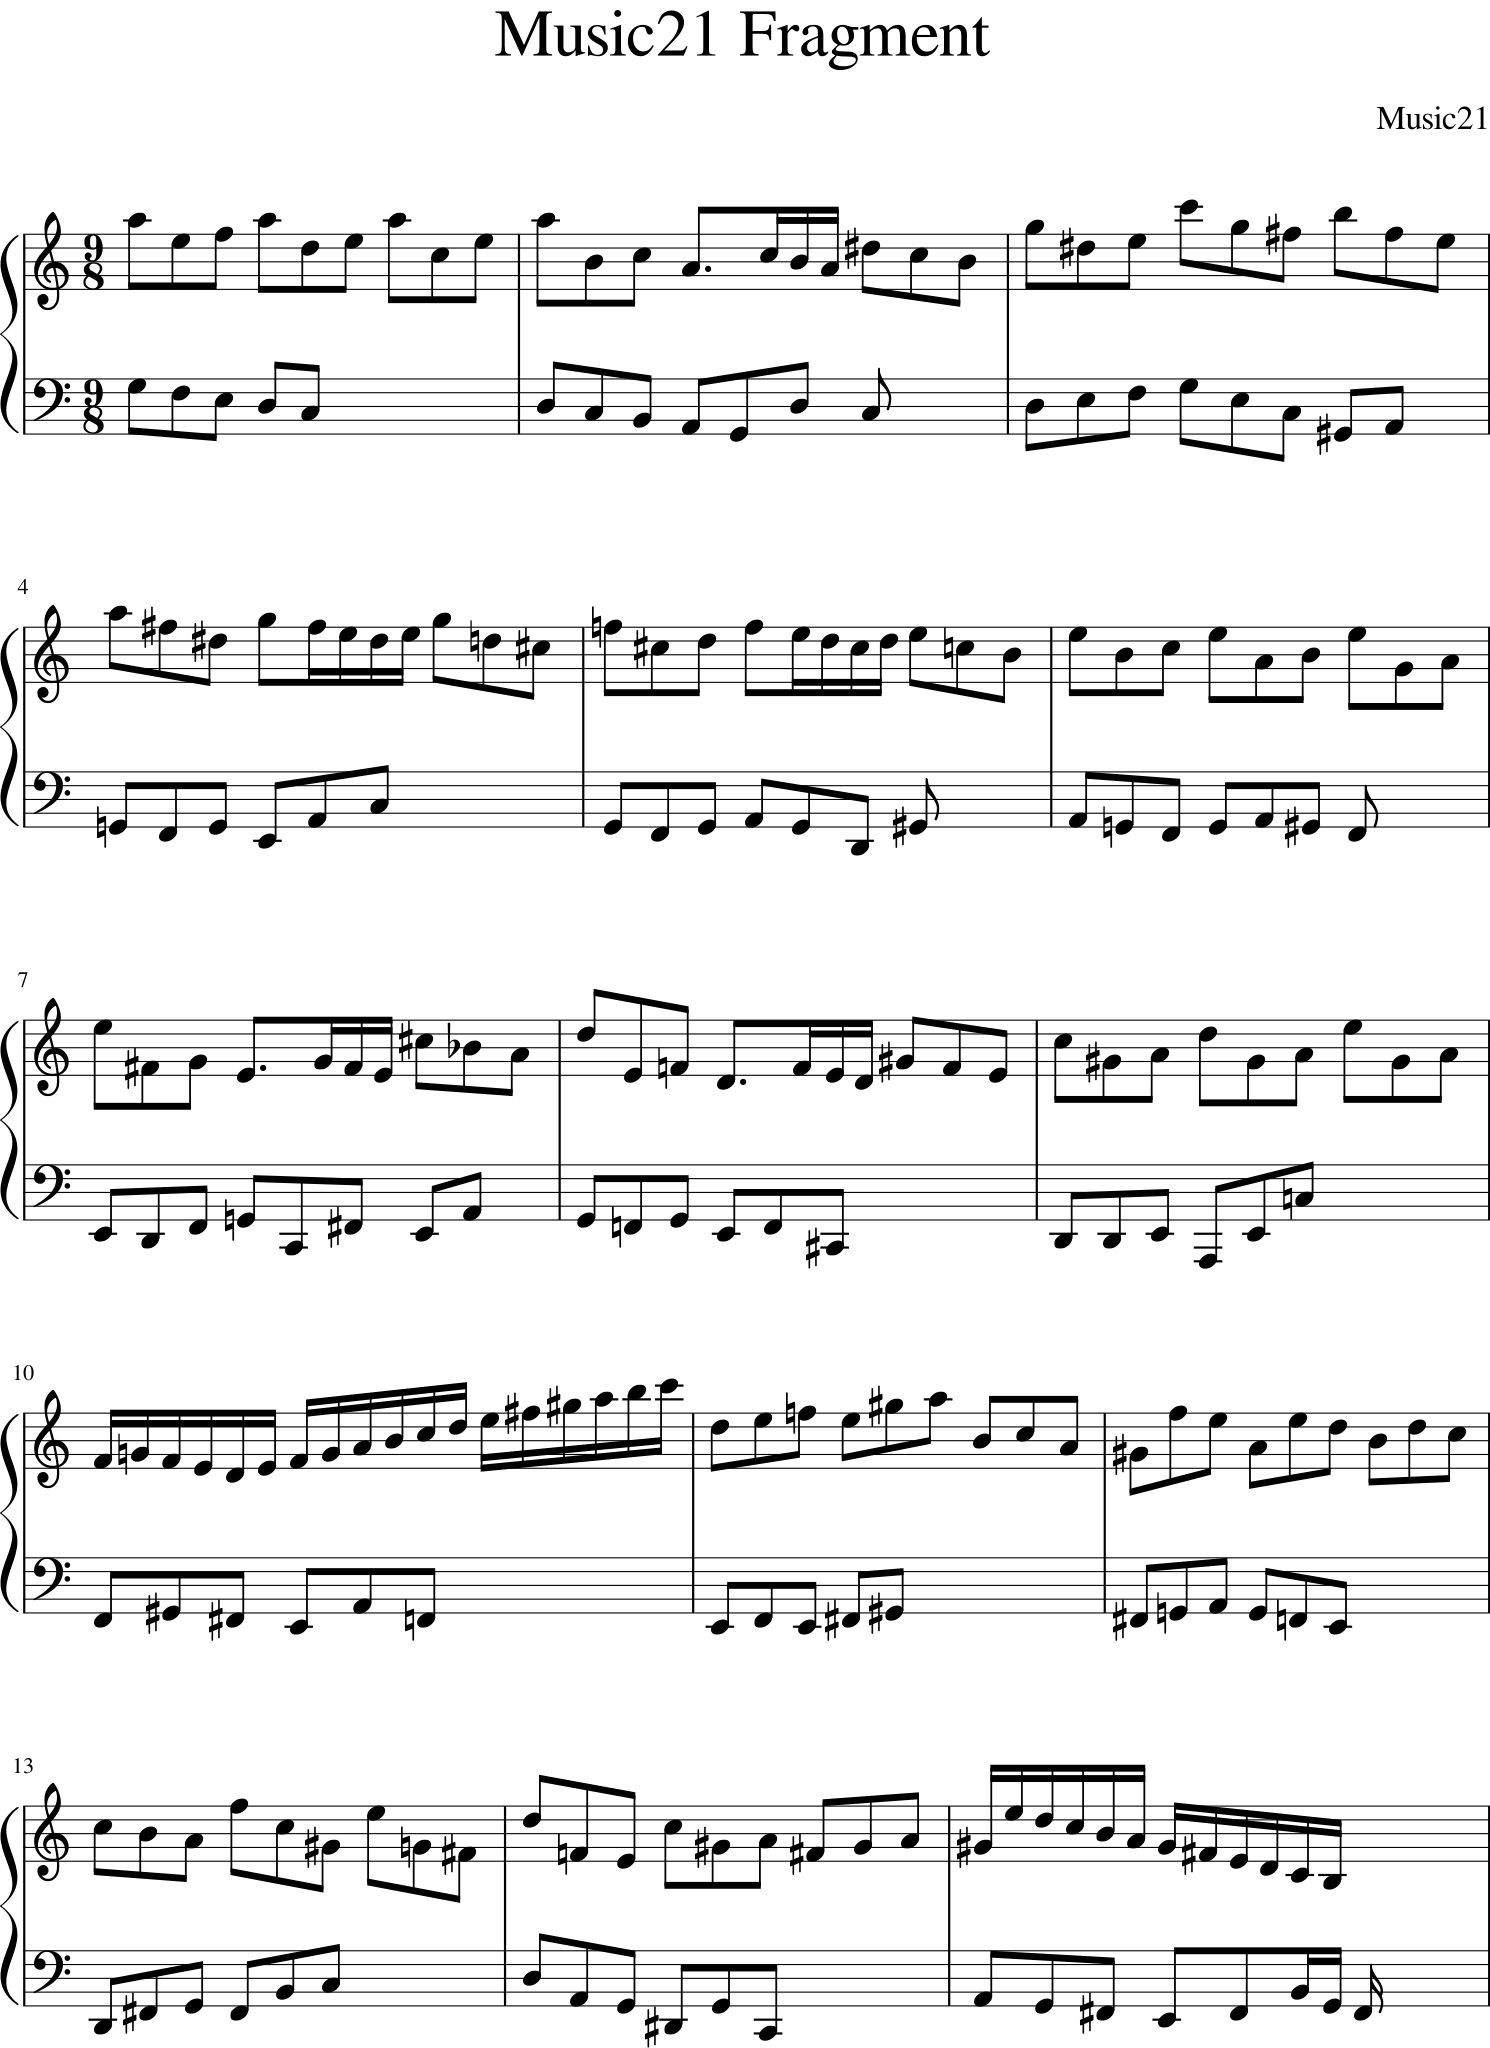

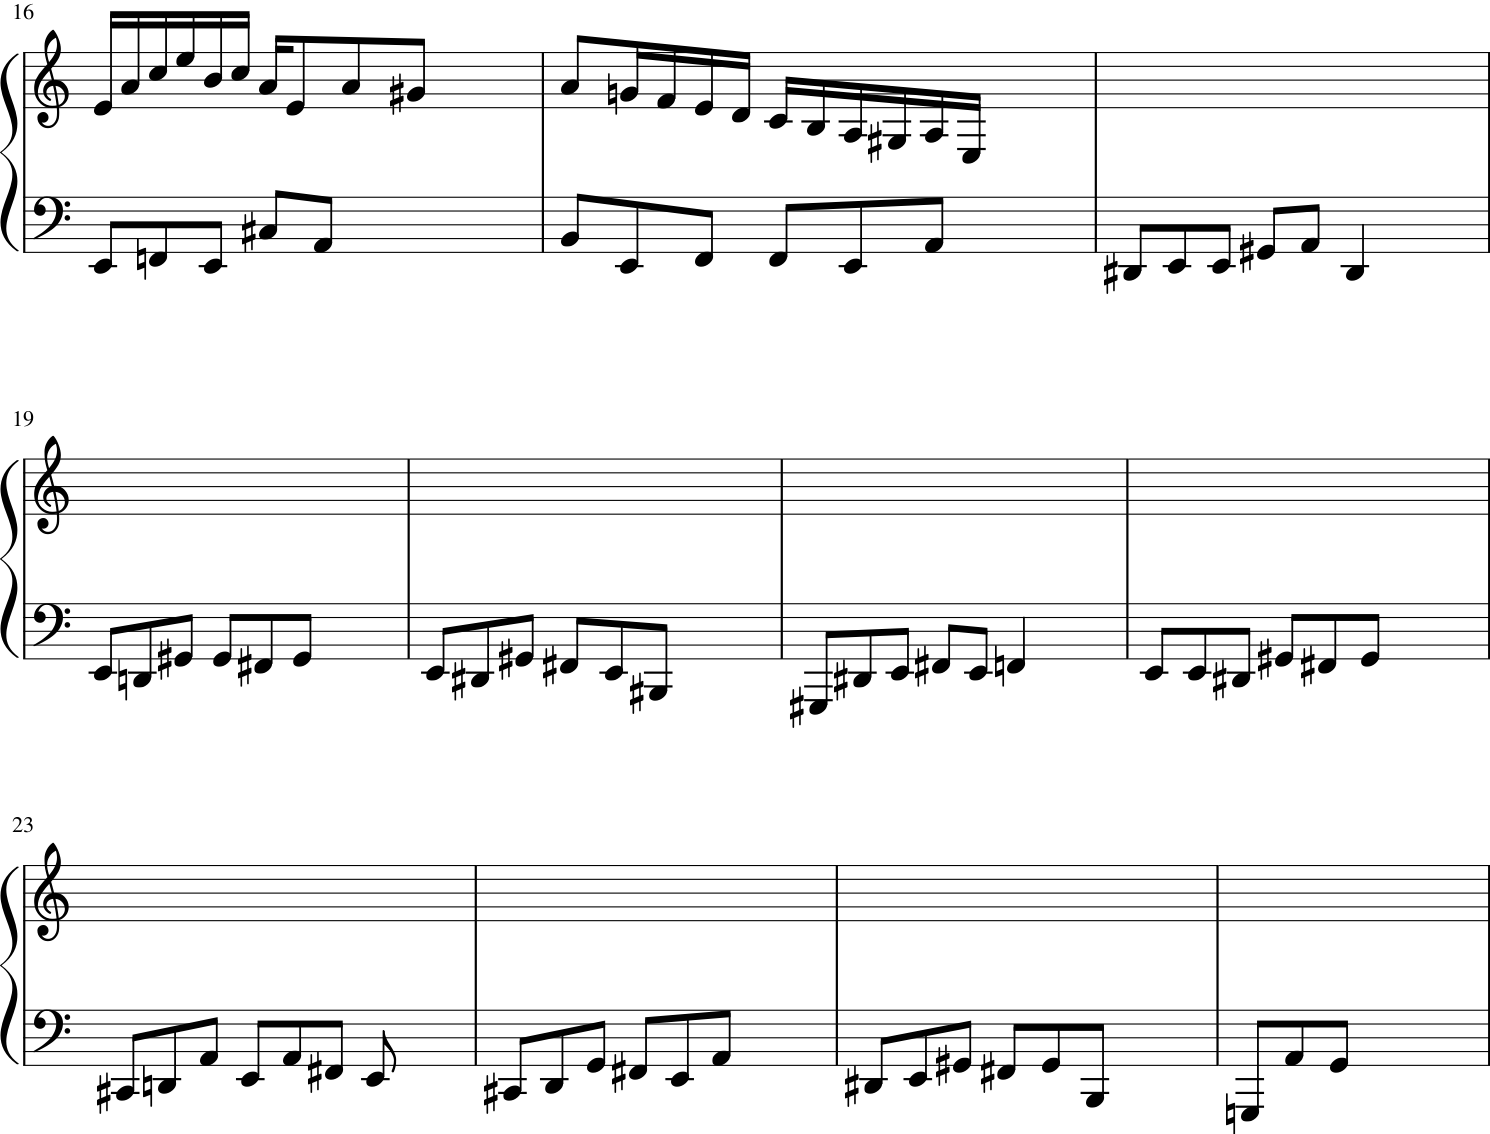

In [ ]:
display_and_play("/content/output2.musicxml")

# Modele TUTO

#### ============= CREATE SAMPLE DATA FILES -> USE THE REAL ONES!=============

In [ ]:
def create_sample_data_files():
    """Create sample pre-tokenized data files for testing"""

    # Create directories
    os.makedirs("data", exist_ok=True)

    # Sample vocabulary (token -> id mapping)
    vocab = {
        "<pad>": 0,
        "<bos>": 1,
        "<eos>": 2,
        "the": 3, "a": 4, "to": 5, "of": 6, "and": 7,
        "in": 8, "is": 9, "it": 10, "for": 11, "on": 12,
        "with": 13, "was": 14, "as": 15, "at": 16, "by": 17,
        "from": 18, "up": 19, "out": 20, "had": 21, "but": 22,
    }

    # Extend vocab to 100 tokens for demo
    for i in range(23, 100):
        vocab[f"token_{i}"] = i

    # Save vocabulary
    with open("data/vocab.json", "w") as f:
        json.dump(vocab, f, indent=2)

    # Generate random pre-tokenized sequences
    # Each sequence: [BOS, random tokens, EOS]
    np.random.seed(42)  # For reproducibility

    def generate_sequences(num_sequences, min_len=5, max_len=20):
        sequences = []
        for _ in range(num_sequences):
            seq_len = np.random.randint(min_len, max_len)
            # Random token IDs between 3-99 (avoiding special tokens 0,1,2)
            tokens = np.random.randint(3, 100, size=seq_len).tolist()
            # Add BOS at start and EOS at end
            sequence = [1] + tokens + [2]
            sequences.append(sequence)
        return sequences

    # Generate train, validation, test sequences
    train_sequences = generate_sequences(100)  # 100 sequences for training
    valid_sequences = generate_sequences(20)   # 20 for validation
    test_sequences = generate_sequences(20)    # 20 for testing

    # Save to files (one sequence per line, space-separated integers)
    def save_sequences(sequences, filepath):
        with open(filepath, "w") as f:
            for seq in sequences:
                f.write(" ".join(map(str, seq)) + "\n")

    save_sequences(train_sequences, "data/train_ids.txt")
    save_sequences(valid_sequences, "data/valid_ids.txt")
    save_sequences(test_sequences, "data/test_ids.txt")

    print("✅ Created sample data files:")
    print("  - data/vocab.json (100 tokens)")
    print("  - data/train_ids.txt (100 sequences)")
    print("  - data/valid_ids.txt (20 sequences)")
    print("  - data/test_ids.txt (20 sequences)")

    return len(vocab)

# Create the sample files
VOCAB_SIZE = create_sample_data_files()

✅ Created sample data files:
  - data/vocab.json (100 tokens)
  - data/train_ids.txt (100 sequences)
  - data/valid_ids.txt (20 sequences)
  - data/test_ids.txt (20 sequences)


#### ============= LOAD DATA FROM FILES =============

In [ ]:
def load_sequences_from_file(filepath):
    """Load pre-tokenized sequences from a file"""
    sequences = []
    with open(filepath, 'r') as f:
        for line in f:
            # Each line contains space-separated integers
            seq = [int(x) for x in line.strip().split()]
            sequences.append(seq)
    return sequences

# Load vocabulary info
# à ne pas mettre car deja fait
'''
with open('data/vocab.json', 'r') as f:
    vocab = json.load(f)
    VOCAB_SIZE = len(vocab)
    BOS_TOKEN_ID = vocab.get('<bos>', 1)
    EOS_TOKEN_ID = vocab.get('<eos>', 2)
    PAD_TOKEN_ID = vocab.get('<pad>', 0)

print(f"\n📊 Vocabulary size: {VOCAB_SIZE}")

print(f"Special tokens - BOS: {BOS_TOKEN_ID}, EOS: {EOS_TOKEN_ID}, PAD: {PAD_TOKEN_ID}")
'''

# Load pre-tokenized sequences
train_sequences = load_sequences_from_file('data/train_ids.txt')
valid_sequences = load_sequences_from_file('data/valid_ids.txt')
test_sequences = load_sequences_from_file('data/test_ids.txt')

print(f"\n📚 Loaded sequences:")
print(f"  Training: {len(train_sequences)} sequences")
print(f"  Validation: {len(valid_sequences)} sequences")
print(f"  Test: {len(test_sequences)} sequences")

# Show example sequence
print(f"\nExample sequence (first training sequence):")
print(f"  Token IDs: {train_sequences[0][:10]}..." if len(train_sequences[0]) > 10 else f"  Token IDs: {train_sequences[0]}")

#### ============= DATASET CLASS =============

In [ ]:
class PostTokenizedDataset(Dataset):
    """Dataset for pre-tokenized integer sequences"""

    def __init__(self, sequences, block_size=128):
        """
        Args:
            sequences: List of lists, each inner list is a sequence of token IDs
            block_size: Maximum sequence length (will chunk longer sequences)
        """
        self.block_size = block_size
        self.examples = []

        # Concatenate all sequences (they already have EOS tokens)
        all_tokens = []
        for seq in sequences:
            all_tokens.extend(seq)

        # Chunk into fixed-size blocks for language modeling
        # This is standard for GPT-2 training
        for i in range(0, len(all_tokens) - block_size + 1, block_size):
            chunk = all_tokens[i:i + block_size]
            if len(chunk) == block_size:  # Only keep full blocks
                self.examples.append(chunk)

        print(f"  Created {len(self.examples)} chunks of size {block_size} from {len(sequences)} sequences")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        """
        For language modeling, we return the same sequence as both input and label.
        HuggingFace's GPT2LMHeadModel internally shifts the labels to predict next tokens.

        Internally, the model does:
        - Input: [A, B, C, D]
        - Predicts: [B, C, D, E]
        - Loss computed on positions 1 to n (ignores position 0 of labels)
        """
        return {
            "input_ids": torch.tensor(self.examples[idx], dtype=torch.long),
            "labels": torch.tensor(self.examples[idx], dtype=torch.long)
        }

#### ============= DATA COLLATOR =============

In [ ]:

class SimpleDataCollator:
    """Simple collator for batching post-tokenized sequences"""
#     Dataset outputs individual examples:
# [1, 23, 45, 67, 89, 12, 34, 56]  # Shape: [128]
# [1, 34, 56, 78, 90, 23, 45, 67]  # Shape: [128]
# [1, 67, 89, 12, 34, 56, 78, 90]  # Shape: [128]
# [1, 45, 67, 89, 12, 34, 56, 78]  # Shape: [128]

# ↓ Collator stacks them ↓

# Batch tensor for GPU/model:
# [[1, 23, 45, 67, 89, 12, 34, 56],
#  [1, 34, 56, 78, 90, 23, 45, 67],
#  [1, 67, 89, 12, 34, 56, 78, 90],
#  [1, 45, 67, 89, 12, 34, 56, 78]]  # Shape: [4, 128]
    def __call__(self, examples):
        # Stack all input_ids and labels
        input_ids = torch.stack([ex["input_ids"] for ex in examples])
        labels = torch.stack([ex["labels"] for ex in examples])

        return {
            "input_ids": input_ids,
            "labels": labels,
        }

#### ============= CONFIGURATION =============

In [ ]:
MAX_LENGTH = 128  # Maximum sequence length for both model and data

print("\n🤖 Configuring model...")

# Small GPT-2 config for testing
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=MAX_LENGTH,  # Maximum position embeddings
    n_ctx=MAX_LENGTH,        # Context size (same as n_positions)
    n_embd=128,              # Hidden size (very small for testing)
    n_layer=2,               # Number of layers (very small for testing)
    n_head=2,                # Number of attention heads
    bos_token_id=BOS_TOKEN_ID,
    eos_token_id=EOS_TOKEN_ID,
    pad_token_id=PAD_TOKEN_ID,
)

# Initialize model from scratch
model = GPT2LMHeadModel(config)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Max sequence length: {MAX_LENGTH} tokens")

#### ============= PREPARE DATASETS =============

In [ ]:

BLOCK_SIZE = MAX_LENGTH  # Use same size for data chunks!

print(f"\n📦 Preparing datasets with block size {BLOCK_SIZE}...")
train_dataset = PostTokenizedDataset(train_sequences, block_size=BLOCK_SIZE)
valid_dataset = PostTokenizedDataset(valid_sequences, block_size=BLOCK_SIZE)
test_dataset = PostTokenizedDataset(test_sequences, block_size=BLOCK_SIZE)

#### ============= TRAINING ARGUMENTS =============

In [ ]:
training_args = TrainingArguments(
    output_dir="./gpt2-pretokenized",
    overwrite_output_dir=True,

    # Training hyperparameters
    num_train_epochs=20,              # Few epochs for testing
    per_device_train_batch_size=4,   # Small batch for testing
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,

    # Learning rate schedule
    learning_rate=5e-4,
    warmup_steps=10,
    weight_decay=0.01,

    # Evaluation and saving - using correct v4.55 syntax
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,

    # Logging
    logging_dir="./logs",
    logging_steps=10,

    # Performance
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    dataloader_num_workers=0,

    # Disable unwanted features
    push_to_hub=False,
    report_to="none",
)

#### ============= TRAIN MODEL =============

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=SimpleDataCollator(),
)

trainer.train()

In [ ]:
# ============= EVALUATE ON VALIDATION =============
print("\n Evaluating on validation set...")
eval_results = trainer.evaluate()
print(f"Validation loss: {eval_results['eval_loss']:.4f}")

# Calculate perplexity
import math
perplexity = math.exp(eval_results['eval_loss']) if eval_results['eval_loss'] < 20 else float("inf")
print(f"Validation perplexity: {perplexity:.2f}")

# ============= EVALUATE ON TEST =============
print("\n Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test loss: {test_results['eval_loss']:.4f}")

test_perplexity = math.exp(test_results['eval_loss']) if test_results['eval_loss'] < 20 else float("inf")
print(f"Test perplexity: {test_perplexity:.2f}")

In [ ]:


# ============= SAVE MODEL =============
trainer.save_model("./final_model")
print("\n💾 Model saved to ./final_model")


# ============= SIMPLE GENERATION TEST =============
device = next(model.parameters()).device
print(f"Model is on device: {device}")

model.eval()
with torch.no_grad():
    # Start with BOS token
    input_ids = torch.tensor([[BOS_TOKEN_ID]], dtype=torch.long).to(device)

    # Generate 15 tokens
    max_length = 15
    for _ in range(max_length):
        outputs = model(input_ids)
        next_token_logits = outputs.logits[0, -1, :]

        # Sample from top-k tokens for more interesting generation
        top_k = 5
        top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_token = top_k_indices[torch.multinomial(probs, 1)].item()

        # Stop if EOS token
        if next_token == EOS_TOKEN_ID:
            break

        # Create new token on same device
        new_token = torch.tensor([[next_token]], dtype=torch.long).to(device)
        input_ids = torch.cat([input_ids, new_token], dim=1)

    generated = input_ids[0].cpu().tolist()
    print(f"Generated token IDs: {generated}")
    print(f"Length: {len(generated)} tokens")